In [1]:
#import ROOT as rt
#from root_numpy import root2array, tree2array
import os, sys
import gpustat
gpustat.print_gpustat()
os.environ['CUDA_VISIBLE_DEVICES']='3'
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

import h5py
import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd

from matplotlib import pyplot as plt
import math
import json
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold

#from root_pandas import read_root
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, merge, Input, LSTM, Masking,GRU, Concatenate, Convolution1D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from prettytable import PrettyTable

print(keras.__version__)


gpu-4-culture-plate-sm  Tue Jul  9 07:06:39 2019
[0] GeForce GTX 1080 | 37'C,   6 % |  7779 /  8114 MB | llayer(7769M)
[1] GeForce GTX 1080 | 51'C,  38 % |  7779 /  8114 MB | thong(7769M)
[2] GeForce GTX 1080 | 30'C,   0 % |   355 /  8114 MB | thong(345M)
[3] GeForce GTX 1080 | 25'C,   0 % |     0 /  8114 MB |
[4] GeForce GTX 1080 | 27'C,   0 % |     0 /  8114 MB |
[5] GeForce GTX 1080 | 67'C,   0 % |  6919 /  8114 MB | thong(6909M)
[6] GeForce GTX 1080 | 28'C,   0 % |     0 /  8114 MB |
[7] GeForce GTX 1080 | 28'C,   0 % |  7329 /  8114 MB | thong(7319M)


Using TensorFlow backend.


2.0.9


### Preprocessing

In [2]:
#x_mean = np.load('mean2017.npy')
#x_std = np.load('std2017.npy')
with h5py.File("data2017_allnode.h5","r") as input_file:
    data_list = input_file["list"][:]
    data_hlf = input_file['hlf'][:]
    label = input_file["label"][:]
    weight = input_file['weight'][:]
    nodeweight = input_file['nodeweight'][:]
    allnode_weight = input_file['sumallnode_weight'][:]
    
skf = StratifiedKFold(n_splits=3, shuffle=True)
skf.get_n_splits(data_hlf, label)

print(type(data_hlf))

<class 'numpy.ndarray'>


In [3]:
print(data_list.shape)
print(data_hlf.shape)
print(label.shape)
print(weight.shape)
print(nodeweight.shape)
print(allnode_weight.shape)

(106794, 8, 7)
(106794, 9)
(106794,)
(106794,)
(106794, 13)
(106794,)


In [4]:
# Balance out the weight by dividing signal weight by 10, and multiply by a factor of 1e6 to have reasonable range
weight = weight * 1e6
weight[label==1] = weight[label==1]/10.

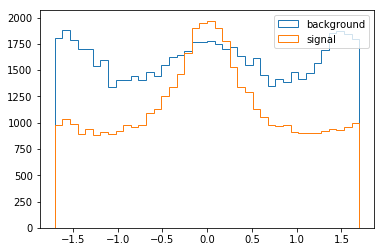

In [5]:
plt.hist(data_hlf[label==0][:,1],weights=weight[label==0]*allnode_weight[label==0],bins=40,histtype='step',label='background')
plt.hist(data_hlf[label==1][:,1],weights=weight[label==1]*allnode_weight[label==1],bins=40,histtype='step',label='signal')
plt.legend(loc='best')

### Training setup

In [6]:
EPOCHS=100
config_file = 'BestConfigInclusiveKeras2017.json'
retrain=True

def build_inclusive_model(name, num_hiddens=2, initial_node=500, 
                          dropout=0.5, gru_layers=2, 
                          gru_size=50, dropout_g=0.1):
    inputs = []
    a = Input(shape=(8, 7))
    inputs.append(a)
    for i in range(gru_layers):
        a = Masking(mask_value=0.0)(a)
        a = GRU(gru_size,
                input_shape=(8, 7),
                return_sequences=True if i < (gru_layers-1) else False)(a)
    a = Dropout(np.float32(dropout_g))(a)
    aHLF = Input(shape=(9,))
    inputs.append(aHLF)
    if(dropout > 0.0):
        aHLF =  Dropout(dropout)(aHLF)
    aHLF = Concatenate(axis=1)([a, aHLF])
    for i in range(num_hiddens):
        aHLF = Dense(int(round(initial_node/np.power(2,i))), activation='relu')(aHLF)
        aHLF =  Dropout(np.float32(dropout))(aHLF)
    dense_final = Dense(1, activation="sigmoid")(aHLF)
    model = Model(input=inputs, output=dense_final)
    return model

def train(num_epochs, model, batch_size, train_data=None, val_data=None, train_weight=None, val_weight=None):
    print("Input data particle shape: {}".format(train_data[0][0].shape))
    print("Input data HLF shape: {}".format(train_data[0][1].shape))
    history = model.fit(x=[train_data[0][0],train_data[0][1]],y=train_data[1],
              nb_epoch=num_epochs,
              sample_weight=train_weight,
              validation_data=([val_data[0][0], val_data[0][1]],val_data[1], val_weight),
              batch_size=batch_size,
              callbacks=[EarlyStopping(verbose=1,patience=10,monitor='val_loss'),
                        ModelCheckpoint(filepath='tmp_best_allnode.h5', monitor='val_loss', save_best_only=True, verbose=1),
                        ReduceLROnPlateau(patience=4, verbose=1, monitor='val_loss', factor=0.2)]
             )
    
    best_acc = max(history.history['val_acc'])
    return best_acc
    
    

### Run the optimization

In [22]:
space  = [Integer(1, 3, name='hidden_layers'),
          Integer(10, 500, name='initial_nodes'),
          Real(0.01,0.9,name='dropout'),
          Integer(1, 3, name='gru_layers'),
          Integer(10, 500, name='gru_size'),
          Real(0.01,0.9,name='dropout_g'),
          Real(10**-5, 10**-1, "log-uniform", name='learning_rate'),
          Integer(32,512,name='batch_size')
          ]

@use_named_args(space)
def objective(**X):
    print("New configuration: {}".format(X))
    fom = []
    for train_index, test_index in skf.split(data_hlf, label):
        print("data_list shape = {}".format(data_list[train_index].shape))
        print("data_hlf shape = {}".format(data_hlf[train_index].shape))
        
        train_data = [data_list[train_index].astype(np.float32), data_hlf[train_index].astype(np.float32)], label[train_index].astype(np.float32)
        test_data = [data_list[test_index].astype(np.float32), data_hlf[test_index].astype(np.float32)], label[test_index].astype(np.float32)
        train_weight = weight[train_index].astype(np.float32)*allnode_weight[train_index].astype(np.float32)
        test_weight = weight[test_index].astype(np.float32)*allnode_weight[test_index].astype(np.float32)
        model = build_inclusive_model("tmp", num_hiddens=X['hidden_layers'], initial_node=X['initial_nodes'], 
                          dropout=X['dropout'], gru_layers=X['gru_layers'], 
                          gru_size=X['gru_size'], dropout_g=X['dropout_g'])
        
        model.compile(optimizer=optimizers.Adam(lr=X['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        
        
#         train_loader = DataLoader(ParticleHLF(data_list[train_index], data_hlf[train_index], label[train_index]), batch_size = X['batch_size'], shuffle=True)
#         val_loader = DataLoader(ParticleHLF(data_list[test_index], data_hlf[test_index], label[test_index]), batch_size = X['batch_size'], shuffle=True)
#         data_loader = {"training": train_loader, "validation": val_loader} 
#         model = InclusiveNetwork(X['hidden_layers'], X['initial_nodes'], X['dropout'], X['gru_layers'], X['gru_size'], X['dropout_g']).cuda()
#         optimizer = AMSGrad(model.parameters(), lr=X['learning_rate'])
#         criterion= nn.NLLLoss()
#         scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode ='min',factor=0.5,patience=4)
#        best_acc = train(EPOCHS, model, criterion, optimizer, scheduler, data_loader=data_loader)
    
        best_acc = train(EPOCHS, model, batch_size=X['batch_size'], 
                         train_data=train_data, val_data=test_data,
                        train_weight=train_weight, val_weight=test_weight)
        fom.append(best_acc)
        
    Y = np.mean(np.asarray(fom))
    print("Average best_acc across k-fold: {}".format(Y))
    return -Y


# train_index, test_index = skf.split(data_hlf, label).next()
# model = InclusiveNetwork(best_hidden_layers, best_initial_nodes, best_dropout, best_gru_layers, best_gru_size, best_dropout_g).cuda()
# train_loader = DataLoader(ParticleHLF(data_list[train_index], data_hlf[train_index], label[train_index]), batch_size = best_batch_size, shuffle=True)
# val_loader = DataLoader(ParticleHLF(data_list[test_index], data_hlf[test_index], label[test_index]), batch_size = best_batch_size, shuffle=True)
# data_loader = {"training": train_loader, "validation": val_loader}
# optimizer = AMSGrad(model.parameters(), lr=best_learning_rate)
# criterion= nn.NLLLoss()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode ='min',factor=0.5,patience=3)
# best_acc = train(EPOCHS, model, criterion, optimizer, scheduler, data_loader=data_loader)
# torch.save(model.state_dict(), model_file)

In [ ]:
res_gp = gp_minimize(objective, space, n_calls=25, random_state=0)

print("Best parameters: {}".format(res_gp.x))
best_hidden_layers = res_gp.x[0]
best_initial_nodes = res_gp.x[1]
best_dropout = res_gp.x[2]
best_gru_layers = res_gp.x[3]
best_gru_size = res_gp.x[4]
best_dropout_g = res_gp.x[5]
best_learning_rate = res_gp.x[6]
best_batch_size = res_gp.x[7]

bestconf = {"hidden_layers": best_hidden_layers,
          "initial_nodes": best_initial_nodes,
          "dropout": best_dropout,
          "gru_layers": best_gru_layers,
          "gru_size": best_gru_size,
          "dropout_g": best_dropout_g,
          "learning_rate": best_learning_rate,
          "batch_size": best_batch_size}
with open(config_file, 'w') as config:
    json.dump(bestconf, config)
    print("Save best configuration to {}".format(config_file))


New configuration: {'hidden_layers': 2, 'dropout_g': 0.35209971949050295, 'initial_nodes': 424, 'dropout': 0.77357159968425371, 'gru_layers': 3, 'batch_size': 59, 'gru_size': 316, 'learning_rate': 0.00015493103643906704}
data_list shape = (565732, 6, 7)
data_hlf shape = (565732, 9)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 6, 7)          0                                            
____________________________________________________________________________________________________
masking_3 (Masking)              (None, 6, 7)          0           input_3[0][0]                    
____________________________________________________________________________________________________
lstm_3 (LSTM)                    (None, 6, 316)        409536      masking_3[0][0]                  
__________

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



541915/565732 [===========================>..] - ETA: 23s - loss: 0.4578 - acc: 0.7789

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



360372/565732 [==================>...........] - ETA: 201s - loss: 0.4576 - acc: 0.7795

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 636s - loss: 0.4569 - acc: 0.7799 - val_loss: 0.4196 - val_acc: 0.8261
Epoch 6/100
142898/565732 [======>.......................] - ETA: 416s - loss: 0.4561 - acc: 0.7798

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 641s - loss: 0.4553 - acc: 0.7807 - val_loss: 0.4178 - val_acc: 0.8266
Epoch 7/100
176941/565732 [========>.....................] - ETA: 383s - loss: 0.4536 - acc: 0.7802

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



548818/565732 [============================>.] - ETA: 16s - loss: 0.4552 - acc: 0.7800

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



323851/565732 [================>.............] - ETA: 237s - loss: 0.4530 - acc: 0.7821

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565692/565732 [============================>.] - ETA: 0s - loss: 0.4533 - acc: 0.7814Epoch 00007: val_acc did not improve

Epoch 00007: reducing learning rate to 3.0986208003e-05.
565732/565732 [==============================] - 636s - loss: 0.4533 - acc: 0.7814 - val_loss: 0.4190 - val_acc: 0.8230
Epoch 9/100
110684/565732 [====>.........................] - ETA: 446s - loss: 0.4540 - acc: 0.7806

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



471292/565732 [=======================>......] - ETA: 92s - loss: 0.4519 - acc: 0.7813

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



248036/565732 [============>.................] - ETA: 312s - loss: 0.4508 - acc: 0.7823

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



287389/565732 [==============>...............] - ETA: 275s - loss: 0.4527 - acc: 0.7820

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565692/565732 [============================>.] - ETA: 0s - loss: 0.4531 - acc: 0.7817Epoch 00010: val_acc did not improve

Epoch 00010: reducing learning rate to 3.0986208003e-05.
565732/565732 [==============================] - 636s - loss: 0.4530 - acc: 0.7817 - val_loss: 0.4165 - val_acc: 0.8175
Epoch 12/100
 95403/565732 [====>.........................] - ETA: 458s - loss: 0.4539 - acc: 0.7799

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



450760/565732 [======================>.......] - ETA: 112s - loss: 0.4506 - acc: 0.7822

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



236413/565732 [===========>..................] - ETA: 322s - loss: 0.4503 - acc: 0.7828

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



410522/565732 [====================>.........] - ETA: 151s - loss: 0.4492 - acc: 0.7829

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



192694/565732 [=========>....................] - ETA: 364s - loss: 0.4490 - acc: 0.7830

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500202/565732 [=========================>....] - ETA: 64s - loss: 0.4497 - acc: 0.7825

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



271872/565732 [=============>................] - ETA: 290s - loss: 0.4503 - acc: 0.7828

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 636s - loss: 0.4496 - acc: 0.7825 - val_loss: 0.4155 - val_acc: 0.8263
Epoch 17/100
 52038/565732 [=>............................] - ETA: 502s - loss: 0.4492 - acc: 0.7830

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



402852/565732 [====================>.........] - ETA: 160s - loss: 0.4487 - acc: 0.7830

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 636s - loss: 0.4493 - acc: 0.7828 - val_loss: 0.4153 - val_acc: 0.8269
Epoch 00016: early stopping
data_list shape = (565732, 6, 7)
data_hlf shape = (565732, 9)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 6, 7)          0                                            
____________________________________________________________________________________________________
masking_9 (Masking)              (None, 6, 7)          0           input_7[0][0]                    
____________________________________________________________________________________________________
lstm_9 (LSTM)                    (None, 6, 316)        409536      masking_9[0][0]                  
___________________________________________________________________________________

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



486809/565732 [========================>.....] - ETA: 77s - loss: 0.4963 - acc: 0.7549

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



272167/565732 [=============>................] - ETA: 287s - loss: 0.4669 - acc: 0.7741

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 634s - loss: 0.4648 - acc: 0.7754 - val_loss: 0.4291 - val_acc: 0.8225
Epoch 3/100
 42421/565732 [=>............................] - ETA: 511s - loss: 0.4590 - acc: 0.7784

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



390875/565732 [===================>..........] - ETA: 171s - loss: 0.4615 - acc: 0.7771

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 634s - loss: 0.4607 - acc: 0.7775 - val_loss: 0.4276 - val_acc: 0.8245
Epoch 4/100
165908/565732 [=======>......................] - ETA: 391s - loss: 0.4609 - acc: 0.7786

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



509170/565732 [==========================>...] - ETA: 55s - loss: 0.4582 - acc: 0.7792

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



291106/565732 [==============>...............] - ETA: 269s - loss: 0.4558 - acc: 0.7805

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 637s - loss: 0.4562 - acc: 0.7799 - val_loss: 0.4224 - val_acc: 0.8247
Epoch 6/100
 67555/565732 [==>...........................] - ETA: 496s - loss: 0.4565 - acc: 0.7789

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



413944/565732 [====================>.........] - ETA: 149s - loss: 0.4552 - acc: 0.7811

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



186558/565732 [========>.....................] - ETA: 371s - loss: 0.4530 - acc: 0.7820

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



531472/565732 [===========================>..] - ETA: 33s - loss: 0.4540 - acc: 0.7818

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



162014/565732 [=======>......................] - ETA: 395s - loss: 0.4531 - acc: 0.7815

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



318659/565732 [===============>..............] - ETA: 241s - loss: 0.4534 - acc: 0.7813

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



509583/565732 [==========================>...] - ETA: 54s - loss: 0.4529 - acc: 0.7816

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



102778/565732 [====>.........................] - ETA: 452s - loss: 0.4526 - acc: 0.7830

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



302670/565732 [===============>..............] - ETA: 257s - loss: 0.4525 - acc: 0.7827

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



453710/565732 [=======================>......] - ETA: 109s - loss: 0.4523 - acc: 0.7826

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 635s - loss: 0.4525 - acc: 0.7824 - val_loss: 0.4192 - val_acc: 0.8261
Epoch 10/100
 66434/565732 [==>...........................] - ETA: 487s - loss: 0.4523 - acc: 0.7829

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



215409/565732 [==========>...................] - ETA: 343s - loss: 0.4528 - acc: 0.7825

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



420788/565732 [=====================>........] - ETA: 141s - loss: 0.4531 - acc: 0.7822

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 637s - loss: 0.4529 - acc: 0.7823 - val_loss: 0.4215 - val_acc: 0.8306
Epoch 11/100
 16638/565732 [..............................] - ETA: 547s - loss: 0.4562 - acc: 0.7779

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



201308/565732 [=========>....................] - ETA: 358s - loss: 0.4503 - acc: 0.7844

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



359074/565732 [==================>...........] - ETA: 203s - loss: 0.4506 - acc: 0.7832

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



535720/565732 [===========================>..] - ETA: 29s - loss: 0.4513 - acc: 0.7823

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



131157/565732 [=====>........................] - ETA: 426s - loss: 0.4509 - acc: 0.7819

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



300664/565732 [==============>...............] - ETA: 259s - loss: 0.4518 - acc: 0.7818

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



548287/565732 [============================>.] - ETA: 17s - loss: 0.4517 - acc: 0.7818

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



319013/565732 [===============>..............] - ETA: 241s - loss: 0.4514 - acc: 0.7823

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 635s - loss: 0.4513 - acc: 0.7826 - val_loss: 0.4158 - val_acc: 0.8223
Epoch 14/100
 91627/565732 [===>..........................] - ETA: 463s - loss: 0.4506 - acc: 0.7836

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



428812/565732 [=====================>........] - ETA: 134s - loss: 0.4509 - acc: 0.7832

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



203019/565732 [=========>....................] - ETA: 354s - loss: 0.4511 - acc: 0.7833

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



532947/565732 [===========================>..] - ETA: 32s - loss: 0.4507 - acc: 0.7834

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



297714/565732 [==============>...............] - ETA: 262s - loss: 0.4487 - acc: 0.7838

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 634s - loss: 0.4480 - acc: 0.7836 - val_loss: 0.4188 - val_acc: 0.8211
Epoch 17/100
 65667/565732 [==>...........................] - ETA: 490s - loss: 0.4501 - acc: 0.7839

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



414003/565732 [====================>.........] - ETA: 148s - loss: 0.4476 - acc: 0.7846

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



181248/565732 [========>.....................] - ETA: 376s - loss: 0.4473 - acc: 0.7843

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



513949/565732 [==========================>...] - ETA: 50s - loss: 0.4479 - acc: 0.7838

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



292817/565732 [==============>...............] - ETA: 267s - loss: 0.4481 - acc: 0.7839

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565692/565732 [============================>.] - ETA: 0s - loss: 0.4481 - acc: 0.7840Epoch 00018: val_acc did not improve

Epoch 00018: reducing learning rate to 6.1972416006e-06.
565732/565732 [==============================] - 635s - loss: 0.4482 - acc: 0.7840 - val_loss: 0.4172 - val_acc: 0.8214
Epoch 20/100
 67732/565732 [==>...........................] - ETA: 488s - loss: 0.4462 - acc: 0.7847

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



416776/565732 [=====================>........] - ETA: 146s - loss: 0.4470 - acc: 0.7846

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



203904/565732 [=========>....................] - ETA: 354s - loss: 0.4475 - acc: 0.7845

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



544924/565732 [===========================>..] - ETA: 20s - loss: 0.4475 - acc: 0.7842

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 93s - loss: 0.4612 - acc: 0.7808 - val_loss: 0.4124 - val_acc: 0.8251
Epoch 4/100
565732/565732 [==============================] - 94s - loss: 0.4578 - acc: 0.7818 - val_loss: 0.4095 - val_acc: 0.8282
Epoch 5/100
565732/565732 [==============================] - 95s - loss: 0.4552 - acc: 0.7827 - val_loss: 0.4079 - val_acc: 0.8297
Epoch 6/100
188993/565732 [=========>....................] - ETA: 54s - loss: 0.4557 - acc: 0.7836

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 93s - loss: 0.4506 - acc: 0.7861 - val_loss: 0.4038 - val_acc: 0.8316
Epoch 10/100
565732/565732 [==============================] - 93s - loss: 0.4500 - acc: 0.7862 - val_loss: 0.4043 - val_acc: 0.8351
Epoch 11/100
565732/565732 [==============================] - 93s - loss: 0.4502 - acc: 0.7858 - val_loss: 0.4061 - val_acc: 0.8301
Epoch 12/100
 34300/565732 [>.............................] - ETA: 76s - loss: 0.4518 - acc: 0.7862

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565607/565732 [============================>.] - ETA: 0s - loss: 0.4468 - acc: 0.7873Epoch 00014: val_acc did not improve

Epoch 00014: reducing learning rate to 4.47316211648e-05.
565732/565732 [==============================] - 94s - loss: 0.4468 - acc: 0.7873 - val_loss: 0.4041 - val_acc: 0.8283
Epoch 16/100
565732/565732 [==============================] - 93s - loss: 0.4462 - acc: 0.7881 - val_loss: 0.4037 - val_acc: 0.8257
Epoch 17/100
553602/565732 [============================>.] - ETA: 1s - loss: 0.4457 - acc: 0.7882

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 93s - loss: 0.4446 - acc: 0.7892 - val_loss: 0.4046 - val_acc: 0.8259
Epoch 21/100
565732/565732 [==============================] - 94s - loss: 0.4447 - acc: 0.7894 - val_loss: 0.4051 - val_acc: 0.8253
Epoch 00020: early stopping
data_list shape = (565732, 6, 7)
data_hlf shape = (565732, 9)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_11 (InputLayer)            (None, 6, 7)          0                                            
____________________________________________________________________________________________________
masking_14 (Masking)             (None, 6, 7)          0           input_11[0][0]                   
____________________________________________________________________________________________________
lstm_14 (LSTM)                   (None, 6, 202)      

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 93s - loss: 0.4557 - acc: 0.7829 - val_loss: 0.4103 - val_acc: 0.8287
Epoch 6/100
565732/565732 [==============================] - 93s - loss: 0.4540 - acc: 0.7838 - val_loss: 0.4073 - val_acc: 0.8307
Epoch 7/100
565732/565732 [==============================] - 93s - loss: 0.4523 - acc: 0.7848 - val_loss: 0.4040 - val_acc: 0.8335
Epoch 8/100
309386/565732 [===============>..............] - ETA: 36s - loss: 0.4521 - acc: 0.7854

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 93s - loss: 0.4488 - acc: 0.7860 - val_loss: 0.4056 - val_acc: 0.8323
Epoch 12/100
565607/565732 [============================>.] - ETA: 0s - loss: 0.4491 - acc: 0.7858Epoch 00011: val_acc did not improve

Epoch 00011: reducing learning rate to 4.47316211648e-05.
565732/565732 [==============================] - 94s - loss: 0.4491 - acc: 0.7858 - val_loss: 0.4038 - val_acc: 0.8286
Epoch 13/100
565732/565732 [==============================] - 93s - loss: 0.4470 - acc: 0.7870 - val_loss: 0.4029 - val_acc: 0.8322
Epoch 14/100
291893/565732 [==============>...............] - ETA: 39s - loss: 0.4472 - acc: 0.7871

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 93s - loss: 0.4463 - acc: 0.7868 - val_loss: 0.4044 - val_acc: 0.8305
Epoch 18/100
565732/565732 [==============================] - 93s - loss: 0.4459 - acc: 0.7871 - val_loss: 0.4038 - val_acc: 0.8296
Epoch 00017: early stopping
data_list shape = (565732, 6, 7)
data_hlf shape = (565732, 9)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_13 (InputLayer)            (None, 6, 7)          0                                            
____________________________________________________________________________________________________
masking_16 (Masking)             (None, 6, 7)          0           input_13[0][0]                   
____________________________________________________________________________________________________
lstm_16 (LSTM)                   (None, 6, 202)      

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 94s - loss: 0.4618 - acc: 0.7806 - val_loss: 0.4183 - val_acc: 0.8260
Epoch 4/100
565732/565732 [==============================] - 94s - loss: 0.4578 - acc: 0.7815 - val_loss: 0.4116 - val_acc: 0.8237
Epoch 5/100
155036/565732 [=======>......................] - ETA: 58s - loss: 0.4558 - acc: 0.7824

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565607/565732 [============================>.] - ETA: 0s - loss: 0.4535 - acc: 0.7829Epoch 00005: val_acc did not improve

Epoch 00005: reducing learning rate to 4.47316211648e-05.
565732/565732 [==============================] - 94s - loss: 0.4535 - acc: 0.7829 - val_loss: 0.4064 - val_acc: 0.8266
Epoch 7/100
565732/565732 [==============================] - 94s - loss: 0.4519 - acc: 0.7842 - val_loss: 0.4059 - val_acc: 0.8293
Epoch 8/100
 82320/565732 [===>..........................] - ETA: 69s - loss: 0.4530 - acc: 0.7849

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 94s - loss: 0.4505 - acc: 0.7856 - val_loss: 0.4043 - val_acc: 0.8275
Epoch 10/100
565732/565732 [==============================] - 93s - loss: 0.4509 - acc: 0.7849 - val_loss: 0.4046 - val_acc: 0.8288
Epoch 11/100
 13034/565732 [..............................] - ETA: 78s - loss: 0.4537 - acc: 0.7832

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 94s - loss: 0.4505 - acc: 0.7854 - val_loss: 0.4020 - val_acc: 0.8287
Epoch 13/100
412972/565732 [====================>.........] - ETA: 22s - loss: 0.4492 - acc: 0.7860

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 95s - loss: 0.4494 - acc: 0.7854 - val_loss: 0.4015 - val_acc: 0.8309
Epoch 15/100
565732/565732 [==============================] - 94s - loss: 0.4497 - acc: 0.7855 - val_loss: 0.4012 - val_acc: 0.8289
Epoch 16/100
249704/565732 [============>.................] - ETA: 45s - loss: 0.4500 - acc: 0.7849

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 94s - loss: 0.4485 - acc: 0.7868 - val_loss: 0.4019 - val_acc: 0.8313
Epoch 19/100
204428/565732 [=========>....................] - ETA: 51s - loss: 0.4480 - acc: 0.7867

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 94s - loss: 0.4489 - acc: 0.7860 - val_loss: 0.4038 - val_acc: 0.8296
Epoch 21/100
565732/565732 [==============================] - 94s - loss: 0.4480 - acc: 0.7866 - val_loss: 0.4034 - val_acc: 0.8305
Epoch 22/100
107702/565732 [====>.........................] - ETA: 66s - loss: 0.4462 - acc: 0.7870

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565607/565732 [============================>.] - ETA: 0s - loss: 0.4478 - acc: 0.7868Epoch 00022: val_acc did not improve

Epoch 00022: reducing learning rate to 8.94632394193e-06.
565732/565732 [==============================] - 94s - loss: 0.4478 - acc: 0.7868 - val_loss: 0.4011 - val_acc: 0.8306
Epoch 24/100
546056/565732 [===========================>..] - ETA: 2s - loss: 0.4472 - acc: 0.7870

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 94s - loss: 0.4473 - acc: 0.7867 - val_loss: 0.4018 - val_acc: 0.8308
Epoch 27/100
400281/565732 [====================>.........] - ETA: 23s - loss: 0.4484 - acc: 0.7864

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 94s - loss: 0.4472 - acc: 0.7873 - val_loss: 0.4021 - val_acc: 0.8308
Epoch 00028: early stopping
Average best_acc across k-fold: 0.833316873252
New configuration: {'hidden_layers': 2, 'dropout_g': 0.72281056926188358, 'initial_nodes': 479, 'dropout': 0.1349121945672542, 'gru_layers': 3, 'batch_size': 358, 'gru_size': 242, 'learning_rate': 0.001207563335135195}
data_list shape = (565732, 6, 7)
data_hlf shape = (565732, 9)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_15 (InputLayer)            (None, 6, 7)          0                                            
____________________________________________________________________________________________________
masking_18 (Masking)             (None, 6, 7)          0           input_15[0][0]                   
____________________

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 142s - loss: 0.3449 - acc: 0.8485 - val_loss: 0.3306 - val_acc: 0.8550
Epoch 3/100
219454/565732 [==========>...................] - ETA: 75s - loss: 0.3419 - acc: 0.8494

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 142s - loss: 0.3399 - acc: 0.8509 - val_loss: 0.3276 - val_acc: 0.8560
Epoch 5/100
 96660/565732 [====>.........................] - ETA: 102s - loss: 0.3365 - acc: 0.8523

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 142s - loss: 0.3389 - acc: 0.8510 - val_loss: 0.3286 - val_acc: 0.8552
Epoch 6/100
565732/565732 [==============================] - 142s - loss: 0.3379 - acc: 0.8515 - val_loss: 0.3279 - val_acc: 0.8561
Epoch 7/100
 26850/565732 [>.............................] - ETA: 116s - loss: 0.3354 - acc: 0.8536

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



457882/565732 [=======================>......] - ETA: 23s - loss: 0.3363 - acc: 0.8521

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 142s - loss: 0.3356 - acc: 0.8525 - val_loss: 0.3270 - val_acc: 0.8563
Epoch 10/100
365160/565732 [==================>...........] - ETA: 43s - loss: 0.3361 - acc: 0.8521

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 142s - loss: 0.3347 - acc: 0.8533 - val_loss: 0.3247 - val_acc: 0.8580
Epoch 12/100
222676/565732 [==========>...................] - ETA: 74s - loss: 0.3333 - acc: 0.8538

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 141s - loss: 0.3339 - acc: 0.8534 - val_loss: 0.3281 - val_acc: 0.8575
Epoch 14/100
218380/565732 [==========>...................] - ETA: 75s - loss: 0.3321 - acc: 0.8542

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 143s - loss: 0.3334 - acc: 0.8537 - val_loss: 0.3280 - val_acc: 0.8555
Epoch 15/100
565732/565732 [==============================] - 145s - loss: 0.3332 - acc: 0.8536 - val_loss: 0.3336 - val_acc: 0.8565
Epoch 16/100
565640/565732 [============================>.] - ETA: 0s - loss: 0.3327 - acc: 0.8537Epoch 00015: val_acc did not improve

Epoch 00015: reducing learning rate to 0.000241512665525.
565732/565732 [==============================] - 142s - loss: 0.3327 - acc: 0.8537 - val_loss: 0.3284 - val_acc: 0.8563
Epoch 17/100
565732/565732 [==============================] - 142s - loss: 0.3295 - acc: 0.8553 - val_loss: 0.3264 - val_acc: 0.8570
Epoch 18/100
565732/565732 [==============================] - 142s - loss: 0.3288 - acc: 0.8553 - val_loss: 0.3265 - val_acc: 0.8569
Epoch 19/100
565732/565732 [==============================] - 141s - loss: 0.3281 - acc: 0.8555 - val_loss: 0.3238 - val_acc: 0.8582
Epoch 20/100
565732/565732 [======

Train on 565732 samples, validate on 282866 samples
Epoch 1/100
565732/565732 [==============================] - 147s - loss: 0.3572 - acc: 0.8424 - val_loss: 0.3331 - val_acc: 0.8545
Epoch 2/100
565732/565732 [==============================] - 140s - loss: 0.3449 - acc: 0.8486 - val_loss: 0.3339 - val_acc: 0.8523
Epoch 3/100
565732/565732 [==============================] - 140s - loss: 0.3419 - acc: 0.8498 - val_loss: 0.3309 - val_acc: 0.8543
Epoch 4/100
565732/565732 [==============================] - 140s - loss: 0.3403 - acc: 0.8504 - val_loss: 0.3327 - val_acc: 0.8554
Epoch 5/100
565732/565732 [==============================] - 140s - loss: 0.3391 - acc: 0.8514 - val_loss: 0.3301 - val_acc: 0.8547
Epoch 6/100
565732/565732 [==============================] - 140s - loss: 0.3384 - acc: 0.8513 - val_loss: 0.3322 - val_acc: 0.8547
Epoch 7/100
565732/565732 [==============================] - 141s - loss: 0.3372 - acc: 0.8517 - val_loss: 0.3271 - val_acc: 0.8559
Epoch 8/100
565732/56573

565732/565732 [==============================] - 185s - loss: 0.3373 - acc: 0.8514 - val_loss: 0.3297 - val_acc: 0.8569
Epoch 7/100
565732/565732 [==============================] - 184s - loss: 0.3364 - acc: 0.8522 - val_loss: 0.3286 - val_acc: 0.8566
Epoch 8/100
565732/565732 [==============================] - 184s - loss: 0.3357 - acc: 0.8529 - val_loss: 0.3286 - val_acc: 0.8565
Epoch 9/100
565732/565732 [==============================] - 184s - loss: 0.3351 - acc: 0.8531 - val_loss: 0.3384 - val_acc: 0.8507
Epoch 10/100
565732/565732 [==============================] - 185s - loss: 0.3345 - acc: 0.8532 - val_loss: 0.3322 - val_acc: 0.8537
Epoch 11/100
565640/565732 [============================>.] - ETA: 0s - loss: 0.3342 - acc: 0.8533Epoch 00010: val_acc did not improve

Epoch 00010: reducing learning rate to 0.000241512665525.
565732/565732 [==============================] - 186s - loss: 0.3342 - acc: 0.8533 - val_loss: 0.3299 - val_acc: 0.8568
Epoch 12/100
565732/565732 [=========

Train on 565732 samples, validate on 282866 samples
Epoch 1/100
565732/565732 [==============================] - 108s - loss: 0.4879 - acc: 0.7636 - val_loss: 0.3734 - val_acc: 0.8410
Epoch 2/100
565732/565732 [==============================] - 102s - loss: 0.4176 - acc: 0.8081 - val_loss: 0.3703 - val_acc: 0.8435
Epoch 3/100
565732/565732 [==============================] - 101s - loss: 0.4093 - acc: 0.8129 - val_loss: 0.3683 - val_acc: 0.8447
Epoch 4/100
565732/565732 [==============================] - 102s - loss: 0.4061 - acc: 0.8144 - val_loss: 0.3669 - val_acc: 0.8451
Epoch 5/100
565732/565732 [==============================] - 102s - loss: 0.4031 - acc: 0.8158 - val_loss: 0.3688 - val_acc: 0.8450
Epoch 6/100
565732/565732 [==============================] - 103s - loss: 0.4017 - acc: 0.8164 - val_loss: 0.3695 - val_acc: 0.8457
Epoch 7/100
565732/565732 [==============================] - 103s - loss: 0.4005 - acc: 0.8162 - val_loss: 0.3689 - val_acc: 0.8456
Epoch 8/100
565732/56573

Train on 565732 samples, validate on 282866 samples
Epoch 1/100
565732/565732 [==============================] - 109s - loss: 0.4864 - acc: 0.7656 - val_loss: 0.3755 - val_acc: 0.8380
Epoch 2/100
565732/565732 [==============================] - 102s - loss: 0.4176 - acc: 0.8086 - val_loss: 0.3683 - val_acc: 0.8429
Epoch 3/100
565732/565732 [==============================] - 102s - loss: 0.4098 - acc: 0.8124 - val_loss: 0.3679 - val_acc: 0.8444
Epoch 4/100
565732/565732 [==============================] - 102s - loss: 0.4057 - acc: 0.8142 - val_loss: 0.3657 - val_acc: 0.8450
Epoch 5/100
565732/565732 [==============================] - 102s - loss: 0.4025 - acc: 0.8162 - val_loss: 0.3675 - val_acc: 0.8450
Epoch 6/100
565732/565732 [==============================] - 102s - loss: 0.4007 - acc: 0.8171 - val_loss: 0.3672 - val_acc: 0.8446
Epoch 7/100
565732/565732 [==============================] - 102s - loss: 0.3991 - acc: 0.8177 - val_loss: 0.3690 - val_acc: 0.8452
Epoch 8/100
565732/56573

Train on 565732 samples, validate on 282866 samples
Epoch 1/100
565732/565732 [==============================] - 64s - loss: 0.3951 - acc: 0.8260 - val_loss: 0.3737 - val_acc: 0.8431
Epoch 2/100
565732/565732 [==============================] - 59s - loss: 0.3917 - acc: 0.8283 - val_loss: 0.3692 - val_acc: 0.8430
Epoch 3/100
565732/565732 [==============================] - 59s - loss: 0.3918 - acc: 0.8284 - val_loss: 0.3758 - val_acc: 0.8402
Epoch 4/100
565732/565732 [==============================] - 59s - loss: 0.3932 - acc: 0.8278 - val_loss: 0.3701 - val_acc: 0.8459
Epoch 5/100
565732/565732 [==============================] - 59s - loss: 0.3924 - acc: 0.8282 - val_loss: 0.3804 - val_acc: 0.8439
Epoch 6/100
565732/565732 [==============================] - 59s - loss: 0.3929 - acc: 0.8280 - val_loss: 0.3749 - val_acc: 0.8427
Epoch 7/100
565732/565732 [==============================] - 59s - loss: 0.3924 - acc: 0.8280 - val_loss: 0.3710 - val_acc: 0.8446
Epoch 8/100
565732/565732 [====

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 59s - loss: 0.3709 - acc: 0.8362 - val_loss: 0.3669 - val_acc: 0.8472
Epoch 26/100
565732/565732 [==============================] - 59s - loss: 0.3708 - acc: 0.8366 - val_loss: 0.3649 - val_acc: 0.8469
Epoch 27/100
565732/565732 [==============================] - 60s - loss: 0.3704 - acc: 0.8363 - val_loss: 0.3667 - val_acc: 0.8473
Epoch 28/100
565192/565732 [============================>.] - ETA: 0s - loss: 0.3710 - acc: 0.8362Epoch 00027: val_acc did not improve

Epoch 00027: reducing learning rate to 6.52399903629e-05.
565732/565732 [==============================] - 59s - loss: 0.3709 - acc: 0.8362 - val_loss: 0.3660 - val_acc: 0.8472
Epoch 29/100
275528/565732 [=============>................] - ETA: 26s - loss: 0.3711 - acc: 0.8359

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 59s - loss: 0.3706 - acc: 0.8363 - val_loss: 0.3656 - val_acc: 0.8471
Epoch 00028: early stopping
data_list shape = (565732, 6, 7)
data_hlf shape = (565732, 9)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_29 (InputLayer)            (None, 6, 7)          0                                            
____________________________________________________________________________________________________
masking_37 (Masking)             (None, 6, 7)          0           input_29[0][0]                   
____________________________________________________________________________________________________
lstm_37 (LSTM)                   (None, 119)           60452       masking_37[0][0]                 
____________________________________________________________________________________

565732/565732 [==============================] - 60s - loss: 0.3710 - acc: 0.8366 - val_loss: 0.3688 - val_acc: 0.8469
Epoch 21/100
565440/565732 [============================>.] - ETA: 0s - loss: 0.3710 - acc: 0.8370Epoch 00020: val_acc did not improve

Epoch 00020: reducing learning rate to 0.000326199945994.
565732/565732 [==============================] - 60s - loss: 0.3710 - acc: 0.8370 - val_loss: 0.3641 - val_acc: 0.8474
Epoch 22/100
565732/565732 [==============================] - 60s - loss: 0.3702 - acc: 0.8370 - val_loss: 0.3628 - val_acc: 0.8475
Epoch 23/100
565732/565732 [==============================] - 60s - loss: 0.3701 - acc: 0.8369 - val_loss: 0.3637 - val_acc: 0.8472
Epoch 00022: early stopping
Average best_acc across k-fold: 0.848175480703
New configuration: {'hidden_layers': 2, 'dropout_g': 0.16210953077108023, 'initial_nodes': 452, 'dropout': 0.098359511819486767, 'gru_layers': 3, 'batch_size': 392, 'gru_size': 330, 'learning_rate': 0.00027077506445052755}
data_l

Train on 565732 samples, validate on 282866 samples
Epoch 1/100
565732/565732 [==============================] - 155s - loss: 0.3587 - acc: 0.8417 - val_loss: 0.3339 - val_acc: 0.8538
Epoch 2/100
565732/565732 [==============================] - 146s - loss: 0.3414 - acc: 0.8499 - val_loss: 0.3284 - val_acc: 0.8558
Epoch 3/100
565732/565732 [==============================] - 147s - loss: 0.3371 - acc: 0.8521 - val_loss: 0.3254 - val_acc: 0.8568
Epoch 4/100
565732/565732 [==============================] - 146s - loss: 0.3357 - acc: 0.8524 - val_loss: 0.3250 - val_acc: 0.8576
Epoch 5/100
565732/565732 [==============================] - 146s - loss: 0.3342 - acc: 0.8531 - val_loss: 0.3273 - val_acc: 0.8558
Epoch 6/100
565732/565732 [==============================] - 146s - loss: 0.3327 - acc: 0.8536 - val_loss: 0.3257 - val_acc: 0.8573
Epoch 7/100
565732/565732 [==============================] - 147s - loss: 0.3323 - acc: 0.8540 - val_loss: 0.3283 - val_acc: 0.8567
Epoch 8/100
565732/56573

565732/565732 [==============================] - 148s - loss: 0.3275 - acc: 0.8558 - val_loss: 0.3240 - val_acc: 0.8580
Epoch 15/100
565732/565732 [==============================] - 147s - loss: 0.3276 - acc: 0.8554 - val_loss: 0.3231 - val_acc: 0.8583
Epoch 16/100
565656/565732 [============================>.] - ETA: 0s - loss: 0.3271 - acc: 0.8560Epoch 00015: val_acc did not improve

Epoch 00015: reducing learning rate to 5.415501073e-05.
565732/565732 [==============================] - 150s - loss: 0.3271 - acc: 0.8560 - val_loss: 0.3234 - val_acc: 0.8582
Epoch 17/100
565732/565732 [==============================] - 148s - loss: 0.3246 - acc: 0.8570 - val_loss: 0.3214 - val_acc: 0.8593
Epoch 18/100
565732/565732 [==============================] - 147s - loss: 0.3238 - acc: 0.8572 - val_loss: 0.3221 - val_acc: 0.8588
Epoch 19/100
565732/565732 [==============================] - 147s - loss: 0.3238 - acc: 0.8573 - val_loss: 0.3223 - val_acc: 0.8584
Epoch 20/100
565732/565732 [========

Train on 565732 samples, validate on 282866 samples
Epoch 1/100
565732/565732 [==============================] - 117s - loss: 0.3504 - acc: 0.8457 - val_loss: 0.3286 - val_acc: 0.8561
Epoch 2/100
565732/565732 [==============================] - 109s - loss: 0.3364 - acc: 0.8526 - val_loss: 0.3276 - val_acc: 0.8573
Epoch 3/100
565732/565732 [==============================] - 109s - loss: 0.3336 - acc: 0.8539 - val_loss: 0.3248 - val_acc: 0.8584
Epoch 4/100
565732/565732 [==============================] - 109s - loss: 0.3316 - acc: 0.8550 - val_loss: 0.3252 - val_acc: 0.8571
Epoch 5/100
565732/565732 [==============================] - 109s - loss: 0.3303 - acc: 0.8557 - val_loss: 0.3234 - val_acc: 0.8592
Epoch 6/100
565732/565732 [==============================] - 109s - loss: 0.3294 - acc: 0.8558 - val_loss: 0.3208 - val_acc: 0.8599
Epoch 7/100
565732/565732 [==============================] - 109s - loss: 0.3283 - acc: 0.8566 - val_loss: 0.3229 - val_acc: 0.8595
Epoch 8/100
565732/56573

565732/565732 [==============================] - 108s - loss: 0.3267 - acc: 0.8574 - val_loss: 0.3237 - val_acc: 0.8578
Epoch 8/100
565732/565732 [==============================] - 109s - loss: 0.3263 - acc: 0.8571 - val_loss: 0.3223 - val_acc: 0.8581
Epoch 9/100
565732/565732 [==============================] - 109s - loss: 0.3257 - acc: 0.8578 - val_loss: 0.3228 - val_acc: 0.8581
Epoch 10/100
565732/565732 [==============================] - 109s - loss: 0.3250 - acc: 0.8580 - val_loss: 0.3253 - val_acc: 0.8573
Epoch 11/100
565732/565732 [==============================] - 109s - loss: 0.3246 - acc: 0.8582 - val_loss: 0.3215 - val_acc: 0.8594
Epoch 12/100
565732/565732 [==============================] - 109s - loss: 0.3241 - acc: 0.8585 - val_loss: 0.3220 - val_acc: 0.8586
Epoch 13/100
565732/565732 [==============================] - 109s - loss: 0.3236 - acc: 0.8586 - val_loss: 0.3220 - val_acc: 0.8585
Epoch 14/100
565732/565732 [==============================] - 109s - loss: 0.3230 - 

Train on 565732 samples, validate on 282866 samples
Epoch 1/100
565732/565732 [==============================] - 116s - loss: 0.3497 - acc: 0.8457 - val_loss: 0.3310 - val_acc: 0.8549
Epoch 2/100
565732/565732 [==============================] - 108s - loss: 0.3357 - acc: 0.8530 - val_loss: 0.3302 - val_acc: 0.8562
Epoch 3/100
565732/565732 [==============================] - 108s - loss: 0.3329 - acc: 0.8545 - val_loss: 0.3255 - val_acc: 0.8568
Epoch 4/100
565732/565732 [==============================] - 108s - loss: 0.3311 - acc: 0.8556 - val_loss: 0.3245 - val_acc: 0.8574
Epoch 5/100
565732/565732 [==============================] - 108s - loss: 0.3298 - acc: 0.8555 - val_loss: 0.3244 - val_acc: 0.8580
Epoch 6/100
565732/565732 [==============================] - 108s - loss: 0.3288 - acc: 0.8562 - val_loss: 0.3220 - val_acc: 0.8593
Epoch 7/100
565732/565732 [==============================] - 108s - loss: 0.3277 - acc: 0.8562 - val_loss: 0.3263 - val_acc: 0.8573
Epoch 8/100
565732/56573

565732/565732 [==============================] - 81s - loss: 0.3857 - acc: 0.8254 - val_loss: 0.3645 - val_acc: 0.8446
Epoch 7/100
565732/565732 [==============================] - 81s - loss: 0.3844 - acc: 0.8263 - val_loss: 0.3614 - val_acc: 0.8481
Epoch 8/100
565732/565732 [==============================] - 81s - loss: 0.3833 - acc: 0.8272 - val_loss: 0.3611 - val_acc: 0.8471
Epoch 9/100
565558/565732 [============================>.] - ETA: 0s - loss: 0.3821 - acc: 0.8280Epoch 00008: val_acc did not improve

Epoch 00008: reducing learning rate to 3.71395784896e-05.
565732/565732 [==============================] - 84s - loss: 0.3821 - acc: 0.8280 - val_loss: 0.3648 - val_acc: 0.8441
Epoch 10/100
565732/565732 [==============================] - 81s - loss: 0.3807 - acc: 0.8288 - val_loss: 0.3626 - val_acc: 0.8449
Epoch 11/100
565732/565732 [==============================] - 81s - loss: 0.3798 - acc: 0.8288 - val_loss: 0.3620 - val_acc: 0.8454
Epoch 12/100
565732/565732 [===============

565732/565732 [==============================] - 82s - loss: 0.3809 - acc: 0.8288 - val_loss: 0.3653 - val_acc: 0.8436
Epoch 9/100
565732/565732 [==============================] - 82s - loss: 0.3801 - acc: 0.8292 - val_loss: 0.3663 - val_acc: 0.8434
Epoch 10/100
565732/565732 [==============================] - 81s - loss: 0.3801 - acc: 0.8295 - val_loss: 0.3649 - val_acc: 0.8448
Epoch 11/100
565558/565732 [============================>.] - ETA: 0s - loss: 0.3800 - acc: 0.8293Epoch 00010: val_acc did not improve

Epoch 00010: reducing learning rate to 7.42791598896e-06.
565732/565732 [==============================] - 81s - loss: 0.3799 - acc: 0.8293 - val_loss: 0.3661 - val_acc: 0.8435
Epoch 12/100
565732/565732 [==============================] - 82s - loss: 0.3794 - acc: 0.8297 - val_loss: 0.3650 - val_acc: 0.8437
Epoch 13/100
565732/565732 [==============================] - 81s - loss: 0.3793 - acc: 0.8291 - val_loss: 0.3648 - val_acc: 0.8439
Epoch 00012: early stopping
data_list sha

565732/565732 [==============================] - 130s - loss: 0.5211 - acc: 0.7705 - val_loss: 0.4771 - val_acc: 0.8103
Epoch 11/100
565732/565732 [==============================] - 130s - loss: 0.5113 - acc: 0.7808 - val_loss: 0.4775 - val_acc: 0.8103
Epoch 12/100
565732/565732 [==============================] - 130s - loss: 0.5089 - acc: 0.7820 - val_loss: 0.4769 - val_acc: 0.8093
Epoch 00011: early stopping
data_list shape = (565732, 6, 7)
data_hlf shape = (565732, 9)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_53 (InputLayer)            (None, 6, 7)          0                                            
____________________________________________________________________________________________________
masking_62 (Masking)             (None, 6, 7)          0           input_53[0][0]                   
___________________

Train on 565732 samples, validate on 282866 samples
Epoch 1/100
565732/565732 [==============================] - 143s - loss: 8.0516 - acc: 0.5002 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/100
565732/565732 [==============================] - 129s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/100
565732/565732 [==============================] - 129s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/100
565732/565732 [==============================] - 129s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/100
565732/565732 [==============================] - 129s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 6/100
565634/565732 [============================>.] - ETA: 0s - loss: 8.0588 - acc: 0.5000Epoch 00005: val_acc did not improve

Epoch 00005: reducing learning rate to 0.00651334226131.
565732/565732 [==============================] - 132s - loss: 8.0590 - acc: 0.5000 - val_loss: 8

565732/565732 [==============================] - 124s - loss: 0.3182 - acc: 0.8602 - val_loss: 0.3195 - val_acc: 0.8599
Epoch 32/100
565732/565732 [==============================] - 125s - loss: 0.3183 - acc: 0.8601 - val_loss: 0.3194 - val_acc: 0.8599
Epoch 33/100
565732/565732 [==============================] - 124s - loss: 0.3183 - acc: 0.8605 - val_loss: 0.3194 - val_acc: 0.8599
Epoch 34/100
565732/565732 [==============================] - 125s - loss: 0.3184 - acc: 0.8600 - val_loss: 0.3194 - val_acc: 0.8599
Epoch 35/100
565554/565732 [============================>.] - ETA: 0s - loss: 0.3183 - acc: 0.8602Epoch 00034: val_acc did not improve

Epoch 00034: reducing learning rate to 2.68363919531e-07.
565732/565732 [==============================] - 125s - loss: 0.3183 - acc: 0.8602 - val_loss: 0.3194 - val_acc: 0.8599
Epoch 36/100
565732/565732 [==============================] - 125s - loss: 0.3181 - acc: 0.8601 - val_loss: 0.3194 - val_acc: 0.8599
Epoch 00035: early stopping
data_l

Train on 565732 samples, validate on 282866 samples
Epoch 1/100
565732/565732 [==============================] - 136s - loss: 0.3511 - acc: 0.8448 - val_loss: 0.3317 - val_acc: 0.8546
Epoch 2/100
565732/565732 [==============================] - 125s - loss: 0.3348 - acc: 0.8529 - val_loss: 0.3258 - val_acc: 0.8574
Epoch 3/100
565732/565732 [==============================] - 125s - loss: 0.3315 - acc: 0.8543 - val_loss: 0.3282 - val_acc: 0.8560
Epoch 4/100
565732/565732 [==============================] - 125s - loss: 0.3297 - acc: 0.8555 - val_loss: 0.3253 - val_acc: 0.8576
Epoch 5/100
565732/565732 [==============================] - 125s - loss: 0.3284 - acc: 0.8560 - val_loss: 0.3248 - val_acc: 0.8574
Epoch 6/100
565732/565732 [==============================] - 125s - loss: 0.3277 - acc: 0.8560 - val_loss: 0.3229 - val_acc: 0.8588
Epoch 7/100
565732/565732 [==============================] - 125s - loss: 0.3268 - acc: 0.8565 - val_loss: 0.3214 - val_acc: 0.8592
Epoch 8/100
565732/56573

565732/565732 [==============================] - 125s - loss: 0.3276 - acc: 0.8565 - val_loss: 0.3246 - val_acc: 0.8578
Epoch 12/100
565732/565732 [==============================] - 125s - loss: 0.3275 - acc: 0.8564 - val_loss: 0.3248 - val_acc: 0.8578
Epoch 13/100
565732/565732 [==============================] - 125s - loss: 0.3270 - acc: 0.8566 - val_loss: 0.3251 - val_acc: 0.8580
Epoch 14/100
565732/565732 [==============================] - 125s - loss: 0.3268 - acc: 0.8568 - val_loss: 0.3248 - val_acc: 0.8577
Epoch 15/100
565732/565732 [==============================] - 125s - loss: 0.3268 - acc: 0.8569 - val_loss: 0.3244 - val_acc: 0.8580
Epoch 16/100
565732/565732 [==============================] - 125s - loss: 0.3264 - acc: 0.8570 - val_loss: 0.3240 - val_acc: 0.8580
Epoch 17/100
565732/565732 [==============================] - 125s - loss: 0.3265 - acc: 0.8569 - val_loss: 0.3237 - val_acc: 0.8585
Epoch 18/100
565732/565732 [==============================] - 125s - loss: 0.3262 

565732/565732 [==============================] - 125s - loss: 0.3371 - acc: 0.8523 - val_loss: 0.3302 - val_acc: 0.8549
Epoch 3/100
565732/565732 [==============================] - 125s - loss: 0.3329 - acc: 0.8543 - val_loss: 0.3284 - val_acc: 0.8564
Epoch 4/100
565732/565732 [==============================] - 125s - loss: 0.3310 - acc: 0.8549 - val_loss: 0.3257 - val_acc: 0.8577
Epoch 5/100
565732/565732 [==============================] - 125s - loss: 0.3299 - acc: 0.8555 - val_loss: 0.3262 - val_acc: 0.8574
Epoch 6/100
565732/565732 [==============================] - 124s - loss: 0.3295 - acc: 0.8555 - val_loss: 0.3253 - val_acc: 0.8577
Epoch 7/100
565732/565732 [==============================] - 125s - loss: 0.3289 - acc: 0.8558 - val_loss: 0.3246 - val_acc: 0.8578
Epoch 8/100
565732/565732 [==============================] - 125s - loss: 0.3286 - acc: 0.8556 - val_loss: 0.3251 - val_acc: 0.8572
Epoch 9/100
565658/565732 [============================>.] - ETA: 0s - loss: 0.3282 - ac

565732/565732 [==============================] - 124s - loss: 0.3258 - acc: 0.8570 - val_loss: 0.3218 - val_acc: 0.8591
Epoch 31/100
565732/565732 [==============================] - 125s - loss: 0.3256 - acc: 0.8572 - val_loss: 0.3218 - val_acc: 0.8590
Epoch 32/100
565732/565732 [==============================] - 124s - loss: 0.3255 - acc: 0.8572 - val_loss: 0.3218 - val_acc: 0.8591
Epoch 33/100
565732/565732 [==============================] - 125s - loss: 0.3257 - acc: 0.8574 - val_loss: 0.3218 - val_acc: 0.8590
Epoch 34/100
565658/565732 [============================>.] - ETA: 0s - loss: 0.3255 - acc: 0.8572Epoch 00033: val_acc did not improve

Epoch 00033: reducing learning rate to 6.53918448279e-08.
565732/565732 [==============================] - 125s - loss: 0.3256 - acc: 0.8572 - val_loss: 0.3218 - val_acc: 0.8590
Epoch 35/100
565732/565732 [==============================] - 124s - loss: 0.3257 - acc: 0.8571 - val_loss: 0.3218 - val_acc: 0.8590
Epoch 36/100
565732/565732 [======

565396/565732 [============================>.] - ETA: 0s - loss: 0.3216 - acc: 0.8591Epoch 00037: val_acc did not improve

Epoch 00037: reducing learning rate to 3.26959229824e-07.
565732/565732 [==============================] - 125s - loss: 0.3216 - acc: 0.8591 - val_loss: 0.3205 - val_acc: 0.8593
Epoch 39/100
565732/565732 [==============================] - 125s - loss: 0.3217 - acc: 0.8591 - val_loss: 0.3205 - val_acc: 0.8593
Epoch 40/100
565732/565732 [==============================] - 125s - loss: 0.3215 - acc: 0.8591 - val_loss: 0.3205 - val_acc: 0.8593
Epoch 41/100
565732/565732 [==============================] - 124s - loss: 0.3216 - acc: 0.8590 - val_loss: 0.3205 - val_acc: 0.8593
Epoch 42/100
565658/565732 [============================>.] - ETA: 0s - loss: 0.3217 - acc: 0.8590Epoch 00041: val_acc did not improve

Epoch 00041: reducing learning rate to 6.53918448279e-08.
565732/565732 [==============================] - 125s - loss: 0.3217 - acc: 0.8590 - val_loss: 0.3205 - va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



216576/565732 [==========>...................] - ETA: 516s - loss: 0.3803 - acc: 0.8283

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 952s - loss: 0.3798 - acc: 0.8285 - val_loss: 0.3458 - val_acc: 0.8472
Epoch 28/100
 21888/565732 [>.............................] - ETA: 803s - loss: 0.3817 - acc: 0.8280

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



391232/565732 [===================>..........] - ETA: 257s - loss: 0.3789 - acc: 0.8290

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 951s - loss: 0.3796 - acc: 0.8287 - val_loss: 0.3458 - val_acc: 0.8474
Epoch 29/100
147840/565732 [======>.......................] - ETA: 616s - loss: 0.3787 - acc: 0.8296

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



504384/565732 [=========================>....] - ETA: 90s - loss: 0.3793 - acc: 0.8289

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



306560/565732 [===============>..............] - ETA: 381s - loss: 0.3802 - acc: 0.8283

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 955s - loss: 0.3789 - acc: 0.8291 - val_loss: 0.3451 - val_acc: 0.8477
Epoch 31/100
 82688/565732 [===>..........................] - ETA: 721s - loss: 0.3817 - acc: 0.8268

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



423744/565732 [=====================>........] - ETA: 210s - loss: 0.3796 - acc: 0.8293

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



236320/565732 [===========>..................] - ETA: 486s - loss: 0.3792 - acc: 0.8298

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



552768/565732 [============================>.] - ETA: 19s - loss: 0.3783 - acc: 0.8300

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



363712/565732 [==================>...........] - ETA: 298s - loss: 0.3770 - acc: 0.8305

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 957s - loss: 0.3780 - acc: 0.8298 - val_loss: 0.3443 - val_acc: 0.8482
Epoch 34/100
154624/565732 [=======>......................] - ETA: 605s - loss: 0.3798 - acc: 0.8285

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



407776/565732 [====================>.........] - ETA: 232s - loss: 0.3787 - acc: 0.8294

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



526528/565732 [==========================>...] - ETA: 57s - loss: 0.3788 - acc: 0.8296

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



211904/565732 [==========>...................] - ETA: 522s - loss: 0.3785 - acc: 0.8299

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



326208/565732 [================>.............] - ETA: 353s - loss: 0.3783 - acc: 0.8298

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 951s - loss: 0.3780 - acc: 0.8301 - val_loss: 0.3442 - val_acc: 0.8481
Epoch 36/100
 10336/565732 [..............................] - ETA: 819s - loss: 0.3786 - acc: 0.8315

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



125856/565732 [=====>........................] - ETA: 650s - loss: 0.3768 - acc: 0.8317

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



377856/565732 [===================>..........] - ETA: 277s - loss: 0.3774 - acc: 0.8302

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



494720/565732 [=========================>....] - ETA: 104s - loss: 0.3778 - acc: 0.8302

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



178560/565732 [========>.....................] - ETA: 571s - loss: 0.3775 - acc: 0.8297

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



295840/565732 [==============>...............] - ETA: 398s - loss: 0.3775 - acc: 0.8299

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 951s - loss: 0.3776 - acc: 0.8299 - val_loss: 0.3438 - val_acc: 0.8482
Epoch 38/100
 35744/565732 [>.............................] - ETA: 788s - loss: 0.3780 - acc: 0.8301

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



223712/565732 [==========>...................] - ETA: 505s - loss: 0.3771 - acc: 0.8306

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



403680/565732 [====================>.........] - ETA: 238s - loss: 0.3772 - acc: 0.8302

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565728/565732 [============================>.] - ETA: 0s - loss: 0.3775 - acc: 0.8299Epoch 00037: val_acc did not improve

Epoch 00037: reducing learning rate to 1.99999994948e-06.
565732/565732 [==============================] - 961s - loss: 0.3775 - acc: 0.8299 - val_loss: 0.3439 - val_acc: 0.8482
Epoch 39/100
  8096/565732 [..............................] - ETA: 816s - loss: 0.3788 - acc: 0.8318

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



181376/565732 [========>.....................] - ETA: 566s - loss: 0.3777 - acc: 0.8302

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



343744/565732 [=================>............] - ETA: 327s - loss: 0.3776 - acc: 0.8303

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



521120/565732 [==========================>...] - ETA: 65s - loss: 0.3773 - acc: 0.8304

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



132672/565732 [======>.......................] - ETA: 639s - loss: 0.3772 - acc: 0.8293

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



291168/565732 [==============>...............] - ETA: 410s - loss: 0.3777 - acc: 0.8295

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



480192/565732 [========================>.....] - ETA: 127s - loss: 0.3767 - acc: 0.8301

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 957s - loss: 0.3770 - acc: 0.8300 - val_loss: 0.3435 - val_acc: 0.8485
Epoch 41/100
 90112/565732 [===>..........................] - ETA: 703s - loss: 0.3753 - acc: 0.8310

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



275264/565732 [=============>................] - ETA: 428s - loss: 0.3768 - acc: 0.8306

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



453344/565732 [=======================>......] - ETA: 165s - loss: 0.3773 - acc: 0.8302

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 953s - loss: 0.3772 - acc: 0.8301 - val_loss: 0.3434 - val_acc: 0.8484
Epoch 42/100
 38752/565732 [=>............................] - ETA: 800s - loss: 0.3792 - acc: 0.8283

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



213472/565732 [==========>...................] - ETA: 524s - loss: 0.3775 - acc: 0.8303

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



389216/565732 [===================>..........] - ETA: 261s - loss: 0.3778 - acc: 0.8303

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 955s - loss: 0.3773 - acc: 0.8305 - val_loss: 0.3436 - val_acc: 0.8484
Epoch 43/100
 63040/565732 [==>...........................] - ETA: 741s - loss: 0.3780 - acc: 0.8299

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



224128/565732 [==========>...................] - ETA: 503s - loss: 0.3769 - acc: 0.8304

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



410272/565732 [====================>.........] - ETA: 229s - loss: 0.3767 - acc: 0.8307

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 951s - loss: 0.3776 - acc: 0.8302 - val_loss: 0.3435 - val_acc: 0.8484
Epoch 44/100
 15776/565732 [..............................] - ETA: 811s - loss: 0.3775 - acc: 0.8310

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



200064/565732 [=========>....................] - ETA: 539s - loss: 0.3777 - acc: 0.8302

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



370816/565732 [==================>...........] - ETA: 287s - loss: 0.3771 - acc: 0.8307

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



557856/565732 [============================>.] - ETA: 11s - loss: 0.3773 - acc: 0.8302

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



157568/565732 [=======>......................] - ETA: 603s - loss: 0.3760 - acc: 0.8300

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



345344/565732 [=================>............] - ETA: 325s - loss: 0.3769 - acc: 0.8306

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



511808/565732 [==========================>...] - ETA: 79s - loss: 0.3773 - acc: 0.8303

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



131840/565732 [=====>........................] - ETA: 639s - loss: 0.3774 - acc: 0.8305

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



296160/565732 [==============>...............] - ETA: 397s - loss: 0.3776 - acc: 0.8298

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



468128/565732 [=======================>......] - ETA: 144s - loss: 0.3772 - acc: 0.8301

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



565732/565732 [==============================] - 958s - loss: 0.3772 - acc: 0.8302 - val_loss: 0.3433 - val_acc: 0.8485
Epoch 47/100
565732/565732 [==============================] - 952s - loss: 0.3773 - acc: 0.8305 - val_loss: 0.3433 - val_acc: 0.8485
Epoch 48/100
565732/565732 [==============================] - 957s - loss: 0.3768 - acc: 0.8304 - val_loss: 0.3433 - val_acc: 0.8485
Epoch 49/100
565696/565732 [============================>.] - ETA: 0s - loss: 0.3767 - acc: 0.8308Epoch 00048: val_acc improved from 0.84854 to 0.84856, saving model to tmp_best_allnode.h5

Epoch 00048: reducing learning rate to 8.00000009349e-08.
565732/565732 [==============================] - 951s - loss: 0.3767 - acc: 0.8308 - val_loss: 0.3433 - val_acc: 0.8486
Epoch 50/100
565732/565732 [==============================] - 957s - loss: 0.3773 - acc: 0.8302 - val_loss: 0.3433 - val_acc: 0.8485
Epoch 51/100
565732/565732 [==============================] - 952s - loss: 0.3775 - acc: 0.8299 - val_loss: 0.343

Train on 565732 samples, validate on 282866 samples
Epoch 1/100
565732/565732 [==============================] - 963s - loss: 0.4784 - acc: 0.7798 - val_loss: 0.4523 - val_acc: 0.7869
Epoch 2/100
565732/565732 [==============================] - 951s - loss: 0.4508 - acc: 0.7875 - val_loss: 0.4462 - val_acc: 0.7900
Epoch 3/100
565732/565732 [==============================] - 954s - loss: 0.4454 - acc: 0.7906 - val_loss: 0.4374 - val_acc: 0.7946
Epoch 4/100
565732/565732 [==============================] - 987s - loss: 0.4366 - acc: 0.7961 - val_loss: 0.4201 - val_acc: 0.8050
Epoch 5/100
565732/565732 [==============================] - 975s - loss: 0.4230 - acc: 0.8046 - val_loss: 0.3977 - val_acc: 0.8188
Epoch 6/100
565732/565732 [==============================] - 975s - loss: 0.4123 - acc: 0.8112 - val_loss: 0.3833 - val_acc: 0.8278
Epoch 7/100
565732/565732 [==============================] - 956s - loss: 0.4056 - acc: 0.8147 - val_loss: 0.3745 - val_acc: 0.8329
Epoch 8/100
565732/56573

### Load the optimized model

In [7]:
#with open(config_file) as f:
#config_file = 'BestConfigInclusiveKeras2017.json'
with open(config_file) as f:
    bestconf = json.load(f)
    print(bestconf)
print("Loaded best configuration from {}".format(config_file))
model = build_inclusive_model("tmp", num_hiddens=bestconf['hidden_layers'], initial_node=bestconf['initial_nodes'], 
                          dropout=bestconf['dropout'], gru_layers=bestconf['gru_layers'], 
                          gru_size=bestconf['gru_size'], dropout_g=bestconf['dropout_g'])
model.compile(optimizer=optimizers.Adam(lr=bestconf['learning_rate']), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

for train_index, test_index in skf.split(data_hlf, label):
    train_data = [data_list[train_index].astype(np.float32), data_hlf[train_index].astype(np.float32)], label[train_index].astype(np.float32)
    test_data = [data_list[test_index].astype(np.float32), data_hlf[test_index].astype(np.float32)], label[test_index].astype(np.float32)
    
    train_weight = weight[train_index].astype(np.float32)*allnode_weight[train_index].astype(np.float32)
    test_weight = weight[test_index].astype(np.float32)*allnode_weight[test_index].astype(np.float32)
    
    best_acc = train(EPOCHS, model, 
                     batch_size=bestconf['batch_size'], 
                     train_data=train_data, val_data=test_data,
                     train_weight=train_weight,
                     val_weight=test_weight)
    break
model.save("Keras2017_allnode.h5")

{'gru_layers': 2, 'learning_rate': 0.0012141768937927327, 'hidden_layers': 3, 'dropout_g': 0.9, 'gru_size': 500, 'dropout': 0.01, 'initial_nodes': 385, 'batch_size': 512}
Loaded best configuration from BestConfigInclusiveKeras2017.json


/nfshome/thong/.local/lib/python3.5/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`
/nfshome/thong/.local/lib/python3.5/site-packages/ipykernel_launcher.py:39: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 7)         0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, 8, 7)         0           input_1[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 8, 500)       762000      masking_1[0][0]                  
__________________________________________________________________________________________________
masking_2 (Masking)             (None, 8, 500)       0           gru_1[0][0]                      
__________________________________________________________________________________________________
gru_2 (GRU

Epoch 16/100
71196/71196 [==============================] - 14s 198us/step - loss: 0.3180 - acc: 0.8678 - val_loss: 0.3120 - val_acc: 0.8718
Epoch 17/100
71196/71196 [==============================] - 14s 197us/step - loss: 0.3173 - acc: 0.8686 - val_loss: 0.3273 - val_acc: 0.8681
Epoch 18/100
71196/71196 [==============================] - 14s 196us/step - loss: 0.3178 - acc: 0.8680 - val_loss: 0.3139 - val_acc: 0.8740
Epoch 19/100
71196/71196 [==============================] - 14s 201us/step - loss: 0.3182 - acc: 0.8679 - val_loss: 0.3093 - val_acc: 0.8730
Epoch 20/100
71196/71196 [==============================] - 14s 198us/step - loss: 0.3156 - acc: 0.8688 - val_loss: 0.3118 - val_acc: 0.8726
Epoch 21/100
71196/71196 [==============================] - 14s 198us/step - loss: 0.3168 - acc: 0.8674 - val_loss: 0.3136 - val_acc: 0.8734
Epoch 22/100
71196/71196 [==============================] - 14s 199us/step - loss: 0.3142 - acc: 0.8696 - val_loss: 0.3095 - val_acc: 0.8728
Epoch 23/100


In [6]:
from keras.models import load_model
model = load_model('Keras2017_allnode.h5')

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 7)         0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, 8, 7)         0           input_1[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 8, 500)       762000      masking_1[0][0]                  
__________________________________________________________________________________________________
masking_2 (Masking)             (None, 8, 500)       0           gru_1[0][0]                      
__________________________________________________________________________________________________
gru_2 (GRU

In [8]:
# pred = model.predict(x=[data_list[0].reshape(1,8,7),data_hlf[0].reshape(1,9)])
# print(pred)
data_list[0]

array([[ 1.34132378, -0.15389732, -0.57296987,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.76263941, -0.30212   ,  1.34049123,  0.        ,  0.        ,
         1.        ,  0.        ],
       [-0.49275546,  0.53356723, -0.83245077,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.79778174,  0.        ,  1.60887642,  0.        ,  0.        ,
         0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])

### Performance on validation set

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Neural network performance
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.1730  |       0.9602      |    0.2721 +/- 0.0116     |
|   0.2667  |       0.9352      |    0.2031 +/- 0.0067     |
|   0.3795  |       0.9002      |    0.1468 +/- 0.0053     |
|   0.7752  |       0.7001      |    0.0400 +/- 0.0022     |
|   0.9062  |       0.5001      |    0.0133 +/- 0.0009     |
|   0.9659  |       0.3001      |    0.0030 +/- 0.0005     |
+-----------+-------------------+--------------------------+


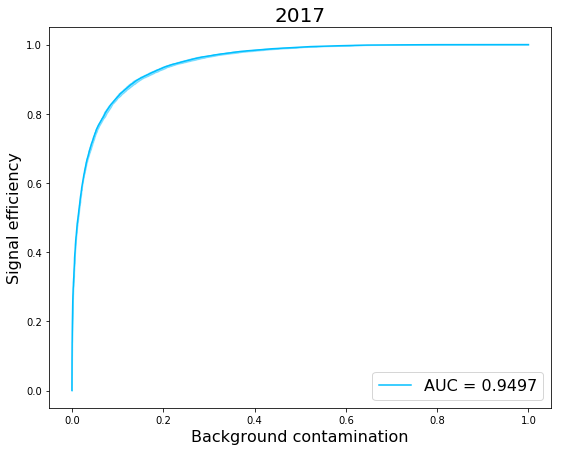

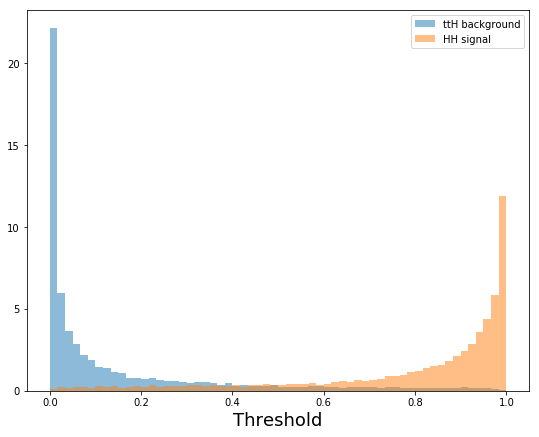

In [9]:
# data_list = np.load("data_list_2017_allnode.npy")
# data_hlf = np.load("data_hlf_2017_allnode.npy")
# label = np.load("label_2017_allnode.npy")
# skf = StratifiedKFold(n_splits=2, shuffle=True)
# skf.get_n_splits(data_hlf, label)
def fill_array(array_to_fill, value, index, batch_size):
    array_to_fill[index*batch_size:min((index+1)*batch_size, array_to_fill.shape[0]),...] = value  

TPR_thresholds = [0.96, 0.935, 0.9, 0.7, 0.5, 0.3]

fprs = []
base_tpr = np.linspace(0, 1, 5000)
thresholds = []
volatile=True
best_batch_size = 1000
for train_index, test_index in skf.split(data_hlf, label):
    train_data = [data_list[train_index].astype(np.float32), data_hlf[train_index].astype(np.float32)], label[train_index].astype(np.float32)
    test_data = [data_list[test_index].astype(np.float32), data_hlf[test_index].astype(np.float32)], label[test_index].astype(np.float32)
    train_weight = weight[train_index].astype(np.float32)*allnode_weight[train_index].astype(np.float32)
    test_weight = weight[test_index].astype(np.float32) *allnode_weight[test_index].astype(np.float32)
    test_label = label[test_index]
    pred = model.predict(x=[test_data[0][0],test_data[0][1]])
    
    fpr, tpr, threshold = roc_curve(test_data[1], pred, sample_weight=test_weight)
    fpr = np.interp(base_tpr, tpr, fpr)
    threshold = np.interp(base_tpr, tpr, threshold)
    fpr[0] = 0.0
    fprs.append(fpr)
    thresholds.append(threshold)

thresholds = np.array(thresholds)
mean_thresholds = thresholds.mean(axis=0)

fprs = np.array(fprs)
mean_fprs = fprs.mean(axis=0)
std_fprs = fprs.std(axis=0)
fprs_right = np.minimum(mean_fprs + std_fprs, 1)
fprs_left = np.maximum(mean_fprs - std_fprs,0)

mean_area = auc(mean_fprs, base_tpr, reorder=True)

print("Neural network performance")
NNtable = PrettyTable(['Threshold','Signal Efficiency','Background Contamination'])
NNtable.float_format = ".4"
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(base_tpr>TPR_threshold)
    NNtable.add_row([mean_thresholds[thres_idx], base_tpr[thres_idx], "{:.4f} +/- {:.4f}".format(mean_fprs[thres_idx], std_fprs[thres_idx])])
print(NNtable)

plt.figure(figsize=(9,7))
plt.plot(mean_fprs, base_tpr,label="AUC = {:.4f}".format(mean_area), color='deepskyblue')
plt.fill_betweenx(base_tpr, fprs_left, fprs_right, color='deepskyblue', alpha=0.4)
plt.legend(loc='best', fontsize=16)
plt.xlabel('Background contamination', fontsize=16)
plt.ylabel('Signal efficiency', fontsize=16)
plt.title('2017', fontsize=20)
#plt.axhline(tpr[thres_idx],ls='--',color='tab:gray')
#plt.axvline(fpr[thres_idx],ls='--',color='tab:gray')

plt.figure(figsize=(9,7))
plt.hist(pred[test_data[1]==0], weights=test_weight[test_data[1]==0], bins=60, label='ttH background',alpha=0.5, normed=True)
plt.hist(pred[test_data[1]==1], weights=test_weight[test_data[1]==1], bins=60, label='HH signal', alpha=0.5, normed=True)
#plt.axvline(thresholds[thres_idx], ls='--',color='tab:gray')
plt.legend(loc='best')
plt.xlabel("Threshold", fontsize=18)

# with h5py.File("ReallyInclusive_ROC.h5","w") as out:
#     out['FPR'] = mean_fprs
#     out['dFPR'] = std_fprs
#     out['TPR'] = base_tpr
#     out['Thresholds'] = mean_thresholds
#     print("Saved ROC.")


### Check on only SM node

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Neural network performance
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.1632  |       0.9602      |    0.2806 +/- 0.0041     |
|   0.2537  |       0.9352      |    0.2111 +/- 0.0011     |
|   0.3635  |       0.9002      |    0.1536 +/- 0.0010     |
|   0.7562  |       0.7001      |    0.0442 +/- 0.0023     |
|   0.8939  |       0.5001      |    0.0158 +/- 0.0016     |
|   0.9587  |       0.3001      |    0.0041 +/- 0.0004     |
+-----------+-------------------+--------------------------+


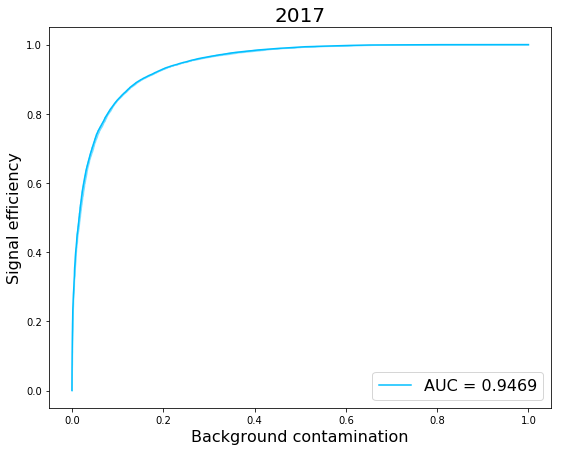

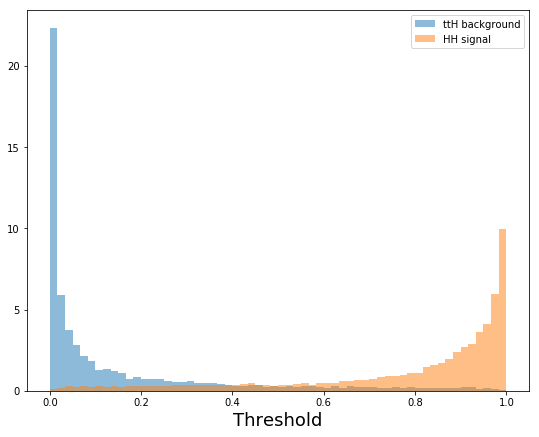

In [12]:


# skf = StratifiedKFold(n_splits=5, shuffle=True)
# skf.get_n_splits(data_hlf, label)

fprs = []
base_tpr_sm = np.linspace(0, 1, 5000)
thresholds = []
volatile=True
best_batch_size = 1000

for train_index, test_index in skf.split(data_hlf, label):
    train_data = [data_list[train_index].astype(np.float32), data_hlf[train_index].astype(np.float32)], label[train_index].astype(np.float32)
    test_data = [data_list[test_index].astype(np.float32), data_hlf[test_index].astype(np.float32)], label[test_index].astype(np.float32)
    train_weight = weight[train_index].astype(np.float32)*nodeweight[train_index,12].astype(np.float32)
    test_weight = weight[test_index].astype(np.float32) *nodeweight[test_index,12].astype(np.float32)
    
    pred = model.predict(x=[test_data[0][0],test_data[0][1]])
    fpr, tpr, threshold = roc_curve(test_data[1], pred, sample_weight=test_weight)
    fpr = np.interp(base_tpr_sm, tpr, fpr)
    threshold = np.interp(base_tpr_sm, tpr, threshold)
    fpr[0] = 0.0
    fprs.append(fpr)
    thresholds.append(threshold)


thresholds = np.array(thresholds)
mean_thresholds = thresholds.mean(axis=0)

fprs = np.array(fprs)
mean_fprs_sm = fprs.mean(axis=0)
std_fprs = fprs.std(axis=0)
fprs_right = np.minimum(mean_fprs_sm + std_fprs, 1)
fprs_left = np.maximum(mean_fprs_sm - std_fprs,0)

mean_area_sm = auc(mean_fprs_sm, base_tpr_sm, reorder=True)

print("Neural network performance")
NNtable = PrettyTable(['Threshold','Signal Efficiency','Background Contamination'])
NNtable.float_format = ".4"
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(base_tpr_sm>TPR_threshold)
    NNtable.add_row([mean_thresholds[thres_idx], base_tpr_sm[thres_idx], "{:.4f} +/- {:.4f}".format(mean_fprs_sm[thres_idx], std_fprs[thres_idx])])
print(NNtable)

plt.figure(figsize=(9,7))
plt.plot(mean_fprs_sm, base_tpr_sm,label="AUC = {:.4f}".format(mean_area_sm), color='deepskyblue')
plt.fill_betweenx(base_tpr_sm, fprs_left, fprs_right, color='deepskyblue', alpha=0.4)
plt.legend(loc='best', fontsize=16)
plt.xlabel('Background contamination', fontsize=16)
plt.ylabel('Signal efficiency', fontsize=16)
plt.title('2017', fontsize=20)
#plt.axhline(tpr[thres_idx],ls='--',color='tab:gray')
#plt.axvline(fpr[thres_idx],ls='--',color='tab:gray')

plt.figure(figsize=(9,7))
plt.hist(pred[test_data[1]==0], weights=test_weight[test_data[1]==0], bins=60, label='ttH background',alpha=0.5, normed=True)
plt.hist(pred[test_data[1]==1], weights=test_weight[test_data[1]==1], bins=60, label='HH signal', alpha=0.5, normed=True)
#plt.axvline(thresholds[thres_idx], ls='--',color='tab:gray')
plt.legend(loc='best')
plt.xlabel("Threshold", fontsize=18)


### BSM node 2

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Node 0
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.1618  |       0.9704      |    0.2831 +/- 0.0077     |
|   0.2528  |       0.9498      |    0.2114 +/- 0.0036     |
|   0.3627  |       0.9196      |    0.1539 +/- 0.0011     |
|   0.7560  |       0.7536      |    0.0442 +/- 0.0032     |
|   0.8938  |       0.5777      |    0.0158 +/- 0.0006     |
|   0.9587  |       0.3837      |    0.0041 +/- 0.0001     |
+-----------+-------------------+--------------------------+


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Node 1
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.1624  |       0.9840      |    0.2814 +/- 0.0029     |
|   0.2533  |       0.9716      |    0.2116 +/- 0.0087     |
|   0.3631  |       0.9502      |    0.1540 +/- 0.0045     |
|   0.7560  |       0.8278      |    0.0444 +/- 0.0007     |
|   0.8938  |       0.6925      |    0.0158 +/- 0.0007     |
|   0.9587  |       0.5177      |    0.0042 +/- 0.0003     |
+-----------+-------------------+--------------------------+


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Node 2
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.1626  |       0.9656      |    0.2816 +/- 0.0107     |
|   0.2532  |       0.9436      |    0.2114 +/- 0.0062     |
|   0.3626  |       0.9110      |    0.1538 +/- 0.0025     |
|   0.7561  |       0.7271      |    0.0443 +/- 0.0008     |
|   0.8938  |       0.5387      |    0.0158 +/- 0.0006     |
|   0.9587  |       0.3411      |    0.0042 +/- 0.0003     |
+-----------+-------------------+--------------------------+


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Node 3
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.1629  |       0.9580      |    0.2810 +/- 0.0071     |
|   0.2534  |       0.9324      |    0.2112 +/- 0.0040     |
|   0.3635  |       0.8962      |    0.1534 +/- 0.0007     |
|   0.7562  |       0.6969      |    0.0442 +/- 0.0011     |
|   0.8938  |       0.4947      |    0.0158 +/- 0.0008     |
|   0.9587  |       0.2967      |    0.0042 +/- 0.0003     |
+-----------+-------------------+--------------------------+


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Node 4
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.1620  |       0.9780      |    0.2818 +/- 0.0060     |
|   0.2529  |       0.9614      |    0.2116 +/- 0.0071     |
|   0.3630  |       0.9358      |    0.1540 +/- 0.0068     |
|   0.7561  |       0.7876      |    0.0442 +/- 0.0011     |
|   0.8939  |       0.6297      |    0.0157 +/- 0.0009     |
|   0.9587  |       0.4399      |    0.0042 +/- 0.0001     |
+-----------+-------------------+--------------------------+


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Node 5
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.1620  |       0.9590      |    0.2821 +/- 0.0080     |
|   0.2533  |       0.9328      |    0.2117 +/- 0.0055     |
|   0.3635  |       0.8960      |    0.1537 +/- 0.0046     |
|   0.7561  |       0.7053      |    0.0444 +/- 0.0011     |
|   0.8939  |       0.5095      |    0.0157 +/- 0.0001     |
|   0.9587  |       0.3181      |    0.0042 +/- 0.0002     |
+-----------+-------------------+--------------------------+


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Node 6
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.1631  |       0.9294      |    0.2809 +/- 0.0058     |
|   0.2532  |       0.8922      |    0.2115 +/- 0.0012     |
|   0.3634  |       0.8416      |    0.1538 +/- 0.0010     |
|   0.7561  |       0.5991      |    0.0441 +/- 0.0021     |
|   0.8939  |       0.3573      |    0.0158 +/- 0.0011     |
|   0.9587  |       0.1712      |    0.0042 +/- 0.0004     |
+-----------+-------------------+--------------------------+


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Node 7
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.1621  |       0.9680      |    0.2817 +/- 0.0055     |
|   0.2535  |       0.9468      |    0.2110 +/- 0.0024     |
|   0.3634  |       0.9156      |    0.1534 +/- 0.0052     |
|   0.7561  |       0.7431      |    0.0442 +/- 0.0028     |
|   0.8938  |       0.5637      |    0.0158 +/- 0.0015     |
|   0.9587  |       0.3705      |    0.0041 +/- 0.0006     |
+-----------+-------------------+--------------------------+


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Node 8
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.1621  |       0.9744      |    0.2816 +/- 0.0025     |
|   0.2533  |       0.9562      |    0.2113 +/- 0.0028     |
|   0.3628  |       0.9286      |    0.1537 +/- 0.0018     |
|   0.7560  |       0.7686      |    0.0444 +/- 0.0009     |
|   0.8939  |       0.6003      |    0.0159 +/- 0.0006     |
|   0.9587  |       0.4067      |    0.0042 +/- 0.0000     |
+-----------+-------------------+--------------------------+


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Node 9
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.1626  |       0.9382      |    0.2809 +/- 0.0073     |
|   0.2536  |       0.9040      |    0.2113 +/- 0.0051     |
|   0.3635  |       0.8578      |    0.1535 +/- 0.0024     |
|   0.7560  |       0.6385      |    0.0444 +/- 0.0013     |
|   0.8938  |       0.4157      |    0.0159 +/- 0.0005     |
|   0.9586  |       0.2318      |    0.0042 +/- 0.0002     |
+-----------+-------------------+--------------------------+


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Node 10
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.1632  |       0.9570      |    0.2815 +/- 0.0110     |
|   0.2532  |       0.9312      |    0.2115 +/- 0.0078     |
|   0.3627  |       0.8954      |    0.1538 +/- 0.0051     |
|   0.7560  |       0.7057      |    0.0442 +/- 0.0010     |
|   0.8938  |       0.5109      |    0.0157 +/- 0.0005     |
|   0.9587  |       0.3205      |    0.0042 +/- 0.0007     |
+-----------+-------------------+--------------------------+


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


Node 11
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.1628  |       0.9434      |    0.2809 +/- 0.0063     |
|   0.2533  |       0.9120      |    0.2113 +/- 0.0025     |
|   0.3633  |       0.8688      |    0.1537 +/- 0.0059     |
|   0.7561  |       0.6443      |    0.0443 +/- 0.0023     |
|   0.8939  |       0.4209      |    0.0158 +/- 0.0015     |
|   0.9587  |       0.2270      |    0.0042 +/- 0.0003     |
+-----------+-------------------+--------------------------+


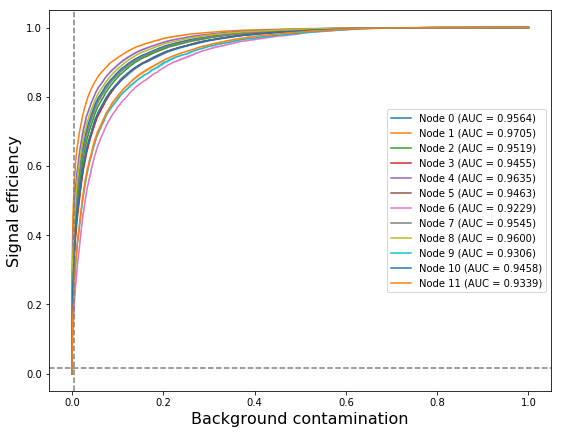

In [16]:
value_thresholds = [0.1632, 0.2537, 0.3635, 0.7562, 0.8939, 0.9587]

# skf = StratifiedKFold(n_splits=5, shuffle=True)
# skf.get_n_splits(data_hlf, label)
plt.figure(figsize=(9,7))

for NODE in range(0,12):
    fprs = []
    base_tpr_node2 = np.linspace(0, 1, 5000)
    thresholds = []
    volatile=True
    best_batch_size = 1000

    for train_index, test_index in skf.split(data_hlf, label):
        train_data = [data_list[train_index].astype(np.float32), data_hlf[train_index].astype(np.float32)], label[train_index].astype(np.float32)
        test_data = [data_list[test_index].astype(np.float32), data_hlf[test_index].astype(np.float32)], label[test_index].astype(np.float32)
        train_weight = weight[train_index].astype(np.float32)*nodeweight[train_index,NODE].astype(np.float32)
        test_weight = weight[test_index].astype(np.float32) *nodeweight[test_index,NODE].astype(np.float32)

        pred = model.predict(x=[test_data[0][0],test_data[0][1]])
        fpr, tpr, threshold = roc_curve(test_data[1], pred, sample_weight=test_weight)
        fpr = np.interp(base_tpr_node2, tpr, fpr)
        threshold = np.interp(base_tpr_node2, tpr, threshold)
        fpr[0] = 0.0
        fprs.append(fpr)
        thresholds.append(threshold)


    thresholds = np.array(thresholds)
    mean_thresholds = thresholds.mean(axis=0)

    fprs = np.array(fprs)
    mean_fprs_node2 = fprs.mean(axis=0)
    std_fprs = fprs.std(axis=0)
    fprs_right = np.minimum(mean_fprs_node2 + std_fprs, 1)
    fprs_left = np.maximum(mean_fprs_node2 - std_fprs,0)

    mean_area_node2 = auc(mean_fprs_node2, base_tpr_node2, reorder=True)

    print("Node {}".format(NODE))
    NNtable = PrettyTable(['Threshold','Signal Efficiency','Background Contamination'])
    NNtable.float_format = ".4"
    for value_threshold in value_thresholds:
        thres_idx = np.argmax(mean_thresholds<value_threshold)
        NNtable.add_row([mean_thresholds[thres_idx], base_tpr_node2[thres_idx], "{:.4f} +/- {:.4f}".format(mean_fprs_node2[thres_idx], std_fprs[thres_idx])])
    print(NNtable)

# plt.figure(figsize=(9,7))
    plt.plot(mean_fprs_node2, base_tpr_node2,label="Node {} (AUC = {:.4f})".format(NODE, mean_area_node2))
    plt.fill_betweenx(base_tpr_node2, fprs_left, fprs_right, alpha=0.4)
    plt.legend(loc='best', fontsize=16)
    plt.xlabel('Background contamination', fontsize=16)
    plt.ylabel('Signal efficiency', fontsize=16)
# plt.title('2017', fontsize=20)
plt.axhline(tpr[thres_idx],ls='--',color='tab:gray')
plt.axvline(fpr[thres_idx],ls='--',color='tab:gray')
plt.legend(loc='best')
plt.show()

# plt.figure(figsize=(9,7))
# plt.hist(pred[test_data[1]==0], weights=test_weight[test_data[1]==0], bins=60, label='ttH background',alpha=0.5, normed=True)
# plt.hist(pred[test_data[1]==1], weights=test_weight[test_data[1]==1], bins=60, label='HH signal', alpha=0.5, normed=True)
# #plt.axvline(thresholds[thres_idx], ls='--',color='tab:gray')
# plt.legend(loc='best')
# plt.xlabel("Threshold", fontsize=18)


### Benchmark ROC

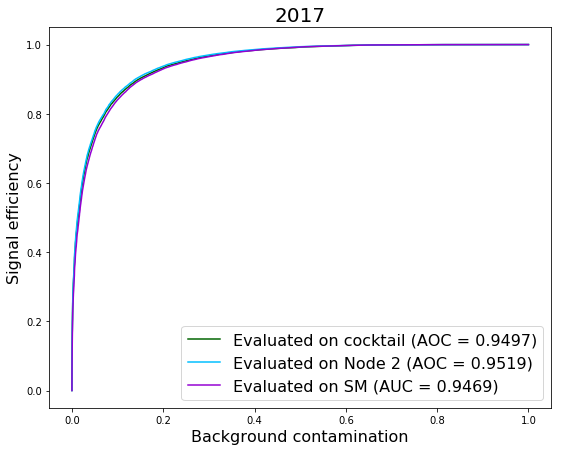

In [23]:
# Benchmark Plot
plt.figure(figsize=(9,7))
plt.plot(mean_fprs, base_tpr,label="Evaluated on cocktail (AOC = {:.4f})".format(mean_area), color='darkgreen')
plt.plot(mean_fprs_node2, base_tpr_node2,label="Evaluated on Node 2 (AOC = {:.4f})".format(mean_area_node2), color='deepskyblue')
plt.plot(mean_fprs_sm, base_tpr_sm, label="Evaluated on SM (AUC = {:.4f})".format(mean_area_sm), color='darkviolet')

plt.legend(loc='best', fontsize=16)
plt.xlabel('Background contamination', fontsize=16)
plt.ylabel('Signal efficiency', fontsize=16)
plt.title('2017', fontsize=20)

In [16]:
sm_in.close()
sm_in_node2.close()

NameError: name 'sm_in' is not defined

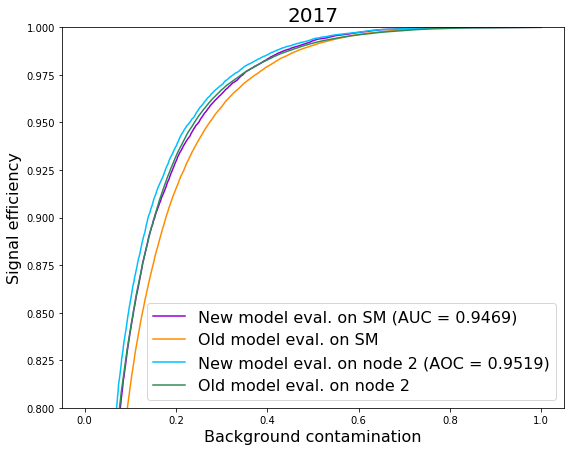

In [24]:
sm_in =  h5py.File("Standard_ROC.h5","r")
sm_in_node2 = h5py.File("SM_on_node2_ROC.h5","r") 
sm_mean_fprs_node2 = sm_in_node2['FPR']
sm_base_tpr_node2 = sm_in_node2['TPR']
sm_mean_fprs = sm_in['FPR']
sm_mean_base_tpr = sm_in['TPR']
plt.figure(figsize=(9,7))
#plt.plot(mean_fprs, base_tpr,label="New model eval. on cocktail (AOC = {:.4f})".format(mean_area), color='black')
plt.plot(mean_fprs_sm, base_tpr_sm, label="New model eval. on SM (AUC = {:.4f})".format(mean_area_sm), color='darkviolet')
plt.plot(sm_mean_fprs, sm_mean_base_tpr, label="Old model eval. on SM", color='darkorange')
plt.plot(mean_fprs_node2, base_tpr_node2,label="New model eval. on node 2 (AOC = {:.4f})".format(mean_area_node2), color='deepskyblue')
plt.plot(sm_mean_fprs_node2, sm_base_tpr_node2, label="Old model eval. on node 2", color='seagreen')

plt.legend(loc='best', fontsize=16)
plt.xlabel('Background contamination', fontsize=16)
plt.ylabel('Signal efficiency', fontsize=16)
#plt.xscale('log')
#plt.xlim((1e-4,1.))
plt.ylim((0.8,1))
plt.title('2017', fontsize=20)

In [43]:
hlf_test = np.array([ -1.1048 , -1.43288 , 0.805159 , -0.433313,  -1.24418 , -0.262744 , 2.12138 , -0.633294 , -1.20308])
hlf_test = hlf_test.reshape((1,9))
pf_test = np.array([
[0.718883 , 1.10485 , -0.00305263 , 0 , 0 , 1 , 0],
[-0.76369 , 0.00234654 , 0.0949781 , 0 , 0 , 0 , 1],
[0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0],
[0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0],
[0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0],
[0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0]   
])
pf_test = pf_test.reshape((1,6,7))
tmp = model.predict(x=[pf_test,hlf_test])
print(tmp)

[[1.187317e-06]]


In [45]:
test_data[0][0][12]

array([[ 0.7290138,  0.6127338, -1.4543222,  0.       ,  0.       ,
         1.       ,  0.       ],
       [-0.5375532,  0.       , -1.1775469,  0.       ,  0.       ,
         0.       ,  1.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ]], dtype=float32)

In [38]:
model.predict(x=[test_data[0][0][5].reshape(1,6,7), test_data[0][1][5].reshape(1,9)])

array([[0.79466844]], dtype=float32)

### On the whole dataset

In [11]:
def fill_array(array_to_fill, value, index, batch_size):
    array_to_fill[index*batch_size:min((index+1)*batch_size, array_to_fill.shape[0]),...] = value

particles_val = np.concatenate((normed_sig_list, normed_bkg_list))
hlf_val = np.concatenate((normed_sig_hlf, normed_bkg_hlf))
y_val = np.concatenate((np.ones(len(normed_sig_hlf)),np.zeros(len(normed_bkg_hlf))))
print(particles_val.shape)
print(hlf_val.shape)
print(y_val.shape)

test_batch_size = 300

all_pred = np.zeros(shape=(len(y_val),2))
test_loader = DataLoader(ParticleHLF(particles_val, hlf_val, y_val), batch_size = test_batch_size, shuffle=False)

model.eval()
volatile=True

for batch_idx, (particles_data, hlf_data, y_data) in enumerate(test_loader):
    particles_data = particles_data.numpy()
    arr = np.sum(particles_data!=0, axis=1)[:,0] # the number of particles in the whole batch
    arr = [1 if x==0 else x for x in arr]
    arr = np.array(arr)
    sorted_indices_la= np.argsort(-arr)
    particles_data = torch.from_numpy(particles_data[sorted_indices_la]).float()
    hlf_data = hlf_data[sorted_indices_la]
    particles_data = Variable(particles_data, volatile=volatile).cuda()
    hlf_data = Variable(hlf_data, volatile).cuda()
    t_seq_length= [arr[i] for i in sorted_indices_la]
    particles_data = torch.nn.utils.rnn.pack_padded_sequence(particles_data, t_seq_length, batch_first=True)

    outputs = model(particles_data, hlf_data)

    # Unsort the predictions (to match the original data order)
    # https://stackoverflow.com/questions/34159608/how-to-unsort-a-np-array-given-the-argsort
    b = np.argsort(sorted_indices_la)
    unsorted_pred = outputs[b].data.cpu().numpy()
    fill_array(all_pred, unsorted_pred, batch_idx, test_batch_size)
    
fpr, tpr, thresholds = roc_curve(y_val, np.exp(all_pred)[:,1])
area = auc(fpr, tpr)

TPR_thresholds = [0.96, 0.935, 0.9, 0.7, 0.5, 0.3]
print("Neural network performance")
NNtable = PrettyTable(['Threshold','Signal Efficiency','Background Contamination'])
NNtable.float_format = ".4"
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    NNtable.add_row([thresholds[thres_idx], tpr[thres_idx],  fpr[thres_idx]])
print(NNtable)
plt.figure(figsize=(9,7))
plt.plot(fpr,tpr,label="NN AUC = {}".format(area))
plt.legend(loc='best')
plt.xlabel('Background contamination')
plt.ylabel('Signal efficiency')
#plt.axhline(tpr[thres_idx],ls='--',color='tab:gray')
#plt.axvline(fpr[thres_idx],ls='--',color='tab:gray')

plt.figure(figsize=(9,7))
plt.hist(np.exp(all_pred)[y_val==0,1], bins=60, label='ttH background',alpha=0.5, normed=True)
plt.hist(np.exp(all_pred)[y_val==1,1], bins=60, label='HH signal', alpha=0.5, normed=True)
#plt.axvline(thresholds[thres_idx], ls='--',color='tab:gray')
plt.legend(loc='best')
plt.xlabel("Threshold", fontsize=18)

sig_frame = pd.DataFrame.from_records(signp)
bkg_frame = pd.DataFrame.from_records(bkgnp)

sig_frame['NN_score'] = pd.Series(np.exp(all_pred[:len(normed_sig_hlf),1]), index=sig_frame.index)
bkg_frame['NN_score'] = pd.Series(np.exp(all_pred[len(normed_sig_hlf):,1]), index=bkg_frame.index)

NameError: name 'normed_sig_list' is not defined

### Check mistagged samples

In [90]:
features_to_check = {
    'sumEt': [40, 0, 2500],
    'MET': [40,0,500],
    'phiMET': [40, -3.15, 3.15],
    'dPhi1': [40, -3.15, 3,15],
    'dPhi2': [40, -3.15, 3,15],
    'PhoJetMinDr': [40, 0, 5],
    'njets': [12, 0, 12],
    'Xtt0': [40, 0, 1000],
    'Xtt1': [40, 0, 1000],
    'pte1': [40, 0, 500],
    'pte2': [40, 0, 500],
    'ptmu1': [40, 0, 500],
    'ptmu2': [40, 0, 500],
    'ptdipho': [40, 0, 1500],
    'etae1': [40, -3.15, 3.15],
    'etae2': [40, -3.15, 3.15],
    'etamu1': [40, -3.15, 3.15],
    'etamu2': [40, -3.15, 3.15],
    'etadipho': [40, -5, 5],
    'phie1': [40, -3.15, 3.15],
    'phie2': [40, -3.15, 3.15],
    'phimu1': [40, -3.15, 3.15],
    'phimu2': [40, -3.15, 3.15],
    'phidipho': [40, -3.15, 3.15],
    'fabs_CosThetaStar_CS': [40, 0, 1],
    'fabs_CosTheta_bb': [40, 0, 1]
}

background_mistag_thres = thresholds[np.argmax(fpr>0.005)]
signal_mistag_thres = thresholds[np.argmax(tpr>0.97)]
print("Threshold for bkg mistag: {}".format(background_mistag_thres))
print("Threshold for signal mistag: {}".format(signal_mistag_thres))

plt.figure(figsize=(9,7))
plt.hist(np.exp(all_pred)[y_val==0,1], bins=60, label='ttH background',alpha=0.5, normed=True)
plt.hist(np.exp(all_pred)[y_val==1,1], bins=60, label='HH signal', alpha=0.5, normed=True)
plt.axvline(background_mistag_thres, ls='--',color='tab:gray')
plt.axvline(signal_mistag_thres, ls='--',color='tab:gray')
plt.legend(loc='best')
plt.xlabel("Threshold", fontsize=18)


for feat in features_to_check:

    plt.figure(figsize=(8,6))
    plt.hist(bkg_frame[feat], bins=features_to_check[feat][0], 
             range=(features_to_check[feat][1], features_to_check[feat][2]),
             label='Full background',
             histtype='stepfilled',
             alpha=0.4,
             normed=True
             )
    plt.hist(sig_frame[feat], bins=features_to_check[feat][0], 
             range=(features_to_check[feat][1], features_to_check[feat][2]),
              label='Full signal',
              histtype='stepfilled',
             alpha=0.4,
             normed=True,
            )
    plt.hist(sig_frame[feat][sig_frame['NN_score']<signal_mistag_thres], bins=features_to_check[feat][0], 
             range=(features_to_check[feat][1], features_to_check[feat][2]),
             label='Signal predicted as bkg',
            histtype='step',
            linewidth=3,
             normed=True,
            )
    plt.hist(bkg_frame[feat][bkg_frame['NN_score']>background_mistag_thres], bins=features_to_check[feat][0], 
             range=(features_to_check[feat][1], features_to_check[feat][2]),
             histtype='step',
             linewidth=3,
             label='Bkg predicted as signal',
             normed=True
            )
    plt.xlabel(feat, fontsize=15)
    plt.yscale('log')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=2, fancybox=True, fontsize=14)


IndexError: index 2544 is out of bounds for axis 0 with size 3

### Check mass sculpting

In [ ]:
fontsize=25

plt.figure(figsize=(9,6))
plt.hist(bkg_aux_frame['mass_jj'], bins=100, histtype='step', label='No cut',normed=True)
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    plt.hist(bkg_aux_frame['mass_jj'][bkg_frame['NN_score']>thresholds[thres_idx]], 
             bins=100, histtype='step', 
             label= "{:.0f}% signal eff".format(100*tpr[thres_idx]),
             normed=True)
plt.legend(loc='best')
plt.ylabel('Background events',fontsize=fontsize)
plt.xlabel(r'$m_{bb}$',fontsize=fontsize)

plt.figure(figsize=(9,6))
plt.hist(sig_aux_frame['mass_jj'], bins=100, histtype='step', label='No cut', normed=True)
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    plt.hist(sig_aux_frame['mass_jj'][sig_frame['NN_score']>thresholds[thres_idx]], 
             bins=100, histtype='step', label= "{:.0f}% signal eff".format(100*tpr[thres_idx]),
             normed=True)
plt.legend(loc='best')
plt.ylabel('Signal events',fontsize=fontsize)
plt.xlabel(r'$m_{bb}$',fontsize=fontsize)

plt.figure(figsize=(9,6))
plt.hist(bkg_aux_frame['mass_gg'], bins=100, range=(115,135), histtype='step', label='No cut', normed=True)
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    plt.hist(bkg_aux_frame['mass_gg'][bkg_frame['NN_score']>thresholds[thres_idx]], 
             bins=100, histtype='step', 
             range=(115,135),
             label= "{:.0f}% signal eff".format(100*tpr[thres_idx]),
             normed=True)
plt.legend(loc='best')
plt.ylabel('Background events',fontsize=fontsize)
plt.xlabel(r'$m_{\gamma \gamma}$',fontsize=fontsize)

plt.figure(figsize=(9,6))
plt.hist(sig_aux_frame['mass_gg'], bins=100, range=(115,135), histtype='step', label='No cut', normed=True)
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    plt.hist(sig_aux_frame['mass_gg'][sig_frame['NN_score']>thresholds[thres_idx]], 
             bins=100, 
             histtype='step', 
             range=(115,135),
             label= "{:.0f}% signal eff".format(100*tpr[thres_idx]),
             normed=True)
plt.legend(loc='best')
plt.ylabel('Signal events',fontsize=fontsize)
plt.xlabel(r'$m_{\gamma \gamma}$',fontsize=fontsize)

### Benchmark

In [ ]:
with h5py.File("DNN_ROC.h5","r") as rocfile:
    fpr_dnn = rocfile['FPR'][:]
    dfpr_dnn = rocfile['dFPR'][:]
    tpr_dnn = rocfile['TPR'][:]
    thres_dnn = rocfile['Thresholds'][:]
    area_dnn = auc(fpr_dnn, tpr_dnn)
    fprs_dnn_right = np.minimum(fpr_dnn + dfpr_dnn, 1)
    fprs_dnn_left = np.maximum(fpr_dnn - dfpr_dnn,0)
    darea_dnn = (1-auc(tpr_dnn,fprs_dnn_left))-area_dnn
    
with h5py.File("BDT_ROC.h5","r") as rocfile:
    fpr_bdt = rocfile['FPR'][:]
    tpr_bdt = rocfile['TPR'][:]
    thres_bdt = rocfile['Thresholds'][:]
    area_bdt = auc(fpr_bdt, tpr_bdt)

with h5py.File("ReallyInclusive_ROC.h5","r") as rocfile:
    fpr_inc = rocfile['FPR'][:]
    dfpr_inc = rocfile['dFPR'][:]
    tpr_inc = rocfile['TPR'][:]
    thres_inc = rocfile['Thresholds'][:]
    area_inc = auc(fpr_inc, tpr_inc)
    fprs_inc_right = np.minimum(fpr_inc + dfpr_dnn, 1)
    fprs_inc_left = np.maximum(fpr_inc - dfpr_dnn,0)
    darea_inc = (1-auc(tpr_inc,fprs_inc_left))-area_inc

### Compare
plt.figure(figsize=(9,7))

plt.plot(fpr_bdt,tpr_bdt,color='blue',label="BDT AUC = {:.4f}".format(area_bdt))


plt.plot(fpr_dnn,tpr_dnn,color='green',label=r"VanillaDNN AUC = {:.4f}$\pm${:.4f}".format(area_dnn, darea_dnn))
plt.fill_betweenx(tpr_dnn, fprs_dnn_left, fprs_dnn_right, color='green', alpha=0.3)


plt.plot(fpr_inc,tpr_inc,color='orange',label=r"InclusiveNet AUC = {:.4f}$\pm${:.4f}".format(area_inc, darea_inc))
plt.fill_betweenx(tpr_inc, fprs_inc_left, fprs_inc_right, color='orange', alpha=0.3)

plt.xlabel('Background contamination',fontsize=18)
plt.ylabel('Signal efficiency',fontsize=18)
# # plt.xlim(0.01,0.6)
# # plt.ylim(0.2,1)
# plt.axhline(tpr[thres_idx],ls='--',color='tab:gray')
# plt.axvline(fpr[thres_idx],ls='--',color='tab:gray')
plt.legend(loc='best',fontsize=15)

In [ ]:
TPR_thresholds = [0.96, 0.935, 0.9, 0.7, 0.5]

table = PrettyTable(['Signal Efficiency','BDT','VanillaDNN','InclusiveNet'])
table.get_string(title="Background contamination at different signal efficiencies")
table.float_format = ".2"
for TPR_threshold in TPR_thresholds:
    thres_dnn = np.argmax(tpr_dnn>TPR_threshold)
    thres_bdt = np.argmax(tpr_bdt>TPR_threshold)
    thres_inc = np.argmax(tpr_inc>TPR_threshold)

    table.add_row(["{:.2f}%".format(100*(tpr_dnn[thres_dnn])),  "{:.2f}%".format(100*fpr_bdt[thres_bdt]), "({:.2f} +/- {:.2f})%".format(100*fpr_dnn[thres_dnn], 100*dfpr_dnn[thres_dnn]), "({:.2f} +/- {:.2f})%".format(100*fpr_inc[thres_inc], 100*dfpr_inc[thres_inc])])
print(table.get_string(title="Background contamination at different signal efficiencies"))

In [ ]:
features = ['pte1','pte2','ptmu1','ptmu2','ptdipho',
            'etae1','etae2','etamu1','etamu2','etadipho',
            'phie1','phie2','phimu1','phimu2','phidipho',
            'MET','phiMET']

for fea in features:
    plt.figure()
    plt.hist(sig_frame[fea][sig_frame[fea]!=0], bins=40, normed=True, 
             histtype='stepfilled', alpha=0.3, label='GluGluToHHTo2B2G Signal')
    plt.hist(bkg_frame[fea][bkg_frame[fea]!=0], bins=40, normed=True, 
             histtype='stepfilled', alpha=0.45, label='ttHToGG Background')
    plt.xlabel(fea,fontsize=15)
    plt.legend(loc='best',fontsize=12)

(array([1.456e+03, 2.635e+03, 2.481e+03, 2.183e+03, 2.038e+03, 1.273e+03,
        9.560e+02, 7.720e+02, 5.780e+02, 4.210e+02, 3.390e+02, 2.480e+02,
        1.850e+02, 1.560e+02, 1.150e+02, 7.500e+01, 8.000e+01, 7.400e+01,
        5.200e+01, 3.200e+01, 3.700e+01, 3.300e+01, 2.400e+01, 2.400e+01,
        1.000e+01, 1.500e+01, 1.300e+01, 6.000e+00, 2.000e+00, 1.200e+01,
        8.000e+00, 3.000e+00, 3.000e+00, 5.000e+00, 3.000e+00, 3.000e+00,
        2.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([-1.24886137, -0.98233134, -0.71580131, -0.44927128, -0.18274124,
         0.08378879,  0.35031882,  0.61684886,  0.88337889,  1.14990892,
         1.41643896,  1.68296899,  1.94949902,  2.21602906,  2.48255909,
         2.74908912,  3.01561916,  3.28214919,  3.54867922,  3.81520926,
         4.08173929,  4.34826932,  4.61479936,  4.88132939,  5.14785942,
         5.

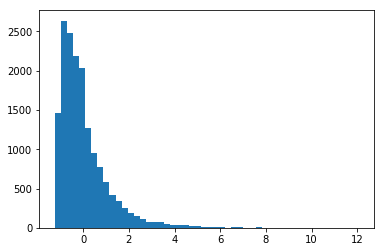

In [57]:
plt.hist(data_hlf[:,0],bins=50)